# 实验二

1. 文献阅读

认真阅读3篇文献资料（自己也可以下载相关文献进行阅读），了解资产定价模型的相关研究，重点关注其中的研究思路和方法。

2. 股票数据实验

尝试找出以0或者6开头，最后两位数字和自己学号最后两位数字一样的股票代码，并从中任意选取8只股票下载2000-2022年的日收益和月收益数据，进行如下实验：
- 利用股票日收益数据对CAPM模型做单资产时间序列检验。
- 利用股票月收益数据对CAPM模型做多资产时间序列检验。

3. 市场效应实证检验

请利用2001-2022年中国A股月度数据实证检验中国A股市市场是具有惯性效应，还是反转效应？（数据请从锐思数据库或者Tushare下载）

**研究思路（参考课本《金融计量学》P48）**

在每个月，计算过去N个月的累积收益率，再根据此累积收益率由低到高排序，构造5个等权重投资组合，并计算持有这些投资组合M个月的累积收益率，追踪投资组合收益率序列，判断中国A股市场存在惯性效应还是反转效应。

- **参数设置**：
  - N = 1, 3, 6, 12
  - M = 1, 3, 6, 12

## 数据选择

我们先用如下脚本来选择尾号为54的股票代码

In [1]:
import requests

def search_stock_by_tail(tail="54"):
    # 定义股票前缀及对应市场标识符
    market_config = [
        {"prefix": "600", "market": "sh"},  # 沪市主板
        {"prefix": "601", "market": "sh"},
        {"prefix": "603", "market": "sh"},
        {"prefix": "605", "market": "sh"},
        {"prefix": "688", "market": "sh"},  # 科创板
        {"prefix": "000", "market": "sz"},  # 深市主板
        {"prefix": "001", "market": "sz"},
        {"prefix": "002", "market": "sz"},  # 中小板
        {"prefix": "003", "market": "sz"},
    ]
    
    results = []
    for config in market_config:
        prefix = config["prefix"]
        market = config["market"]
        
        # 生成中间位0-9循环的代码 (如600054, 600154, ..., 600954)
        for middle in range(10):
            code = f"{prefix}{middle}{tail}"  # 直接拼接6位代码
            url = f"http://qt.gtimg.cn/q=s_{market}{code}" # 腾讯财经
            
            try:
                response = requests.get(url, timeout=5)
                response.encoding = "gbk"
                data = response.text
                
                if "~" in data:
                    name = data.split("~")[1]
                    results.append({"code": code, "name": name})
            except:
                continue
    
    return results

stocks = search_stock_by_tail(tail="54")
for stock in stocks:
    print(f"代码: {stock['code']} | 名称: {stock['name']}")

代码: 600054 | 名称: 黄山旅游
代码: 600354 | 名称: 敦煌种业
代码: 600654 | 名称: 中安科
代码: 600754 | 名称: 锦江酒店
代码: 600854 | 名称: 春兰股份
代码: 000554 | 名称: 泰山石油
代码: 002054 | 名称: 德美化工
代码: 002154 | 名称: 报 喜 鸟
代码: 002254 | 名称: 泰和新材
代码: 002354 | 名称: 天娱数科
代码: 002454 | 名称: 松芝股份
代码: 002554 | 名称: 惠博普
代码: 002654 | 名称: 万润科技


由于我们只要取8只作为实验数据，所以选择如下：

```
代码: 600054 | 名称: 黄山旅游
代码: 600354 | 名称: 敦煌种业
代码: 600654 | 名称: 中安科
代码: 600754 | 名称: 锦江酒店
代码: 600854 | 名称: 春兰股份
代码: 000554 | 名称: 泰山石油
代码: 002054 | 名称: 德美化工
代码: 002154 | 名称: 报 喜 鸟
```

## 数据爬取

我们利用Tushare的api，对如上的股票信息进行爬取，并存储数据。

由于我没有下载月数据的权限，所以我们这里直接计算代替。

In [2]:
import tushare as ts
import pandas as pd
import os
import time

def create_directory(path):
    """创建目录，如果目录不存在"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"创建目录: {path}")

def format_stock_code(code):
    """根据股票代码格式化为tushare所需的格式"""
    code = str(code)
    if code.startswith('6'):
        return f"{code}.SH"  # 上海证券交易所
    elif code.startswith('0') or code.startswith('3'):
        return f"{code}.SZ"  # 深圳证券交易所
    return code

def get_stock_daily_data(pro, ts_code, start_date, end_date):
    """获取股票日线数据"""
    try:
        df = pro.daily(ts_code=ts_code, start_date=start_date, end_date=end_date)
        # 按照日期升序排序
        df = df.sort_values('trade_date', ascending=True)
        return df
    except Exception as e:
        print(f"获取股票 {ts_code} 日线数据失败: {e}")
        return None

def calculate_daily_returns(df):
    """计算日收益率"""
    if df is None or df.empty:
        return None
        
    # 确保数据按日期排序
    df = df.sort_values('trade_date', ascending=True)
    
    # 计算日收益率 (当日收盘价/前日收盘价 - 1)
    df['daily_return'] = df['close'].pct_change()
    
    # 第一行的收益率为NaN，设置为0
    df.loc[df.index[0], 'daily_return'] = 0
    
    return df

def calculate_monthly_returns(daily_df):
    """从日线数据计算月度收益率"""
    if daily_df is None or daily_df.empty:
        return None
    
    # 将交易日期字符串转换为日期对象
    daily_df['date'] = pd.to_datetime(daily_df['trade_date'], format='%Y%m%d')
    
    # 提取年月信息
    daily_df['year_month'] = daily_df['date'].dt.strftime('%Y%m')
    
    # 获取每个月的第一个和最后一个交易日的收盘价
    monthly_data = []
    for year_month, group in daily_df.groupby('year_month'):
        group = group.sort_values('date')
        first_day = group.iloc[0]
        last_day = group.iloc[-1]
        
        monthly_data.append({
            'ts_code': first_day['ts_code'],
            'trade_date': year_month + '01',  # 使用月份的第一天作为标识
            'year_month': year_month,
            'open': first_day['open'],
            'close': last_day['close'],
            'high': group['high'].max(),
            'low': group['low'].min(),
            'vol': group['vol'].sum(),
            'amount': group['amount'].sum(),
            'first_day': first_day['trade_date'],
            'last_day': last_day['trade_date']
        })
    
    # 创建月度DataFrame
    monthly_df = pd.DataFrame(monthly_data)
    monthly_df = monthly_df.sort_values('year_month')
    
    # 计算月度收益率
    monthly_df['monthly_return'] = monthly_df['close'].pct_change()
    monthly_df.loc[monthly_df.index[0], 'monthly_return'] = 0
    
    return monthly_df

def get_and_store_stock_data():
    # Tushare token
    ts.set_token('903410572598901f5f2b8dc42698829afb5fcd12c0cdaa5e11f5c92b')
    pro = ts.pro_api()
    
    # 设置日期范围
    start_date = '20000101'
    end_date = '20221231'
    
    # 股票代码列表
    stock_list = [
        {'code': '600054', 'name': '黄山旅游'},
        {'code': '600354', 'name': '敦煌种业'},
        {'code': '600654', 'name': '中安科'},
        {'code': '600754', 'name': '锦江酒店'},
        {'code': '600854', 'name': '春兰股份'},
        {'code': '000554', 'name': '泰山石油'},
        {'code': '002054', 'name': '德美化工'},
        {'code': '002154', 'name': '报喜鸟'}
    ]
    
    # 对每个股票代码进行处理
    for stock in stock_list:
        code = stock['code']
        name = stock['name']
        ts_code = format_stock_code(code)
        
        print(f"\n开始处理股票: {code} | {name} ({ts_code})")
        
        # 创建存储目录
        daily_dir = f"./assets/data/stock/{code}/daily"
        monthly_dir = f"./assets/data/stock/{code}/monthly"
        create_directory(daily_dir)
        create_directory(monthly_dir)
        
        # 获取日线数据
        print(f"获取 {code} 日线数据...")
        daily_df = get_stock_daily_data(pro, ts_code, start_date, end_date)
        
        if daily_df is not None and not daily_df.empty:
            # 计算日收益率
            daily_df_with_returns = calculate_daily_returns(daily_df)
            # 保存到CSV
            daily_file = f"{daily_dir}/{code}_daily_returns.csv"
            daily_df_with_returns.to_csv(daily_file, index=False)
            print(f"日线数据已保存到: {daily_file}, 共 {len(daily_df_with_returns)} 条记录")
            
            # 根据日线数据计算月线数据
            print(f"计算 {code} 月线数据...")
            monthly_df = calculate_monthly_returns(daily_df)
            if monthly_df is not None and not monthly_df.empty:
                # 保存到CSV
                monthly_file = f"{monthly_dir}/{code}_monthly_returns.csv"
                monthly_df.to_csv(monthly_file, index=False)
                print(f"月线数据已保存到: {monthly_file}, 共 {len(monthly_df)} 条记录")
            else:
                print(f"无法计算 {code} 月线数据")
        else:
            print(f"无法获取 {code} 日线数据")
        
        # 避免频繁请求被限流
        time.sleep(1)

get_and_store_stock_data()


开始处理股票: 600054 | 黄山旅游 (600054.SH)
获取 600054 日线数据...
日线数据已保存到: ./assets/data/stock/600054/daily/600054_daily_returns.csv, 共 5507 条记录
计算 600054 月线数据...
月线数据已保存到: ./assets/data/stock/600054/monthly/600054_monthly_returns.csv, 共 276 条记录

开始处理股票: 600354 | 敦煌种业 (600354.SH)
获取 600354 日线数据...
日线数据已保存到: ./assets/data/stock/600354/daily/600354_daily_returns.csv, 共 4468 条记录
计算 600354 月线数据...
月线数据已保存到: ./assets/data/stock/600354/monthly/600354_monthly_returns.csv, 共 227 条记录

开始处理股票: 600654 | 中安科 (600654.SH)
获取 600654 日线数据...
日线数据已保存到: ./assets/data/stock/600654/daily/600654_daily_returns.csv, 共 5007 条记录
计算 600654 月线数据...
月线数据已保存到: ./assets/data/stock/600654/monthly/600654_monthly_returns.csv, 共 258 条记录

开始处理股票: 600754 | 锦江酒店 (600754.SH)
获取 600754 日线数据...
日线数据已保存到: ./assets/data/stock/600754/daily/600754_daily_returns.csv, 共 5360 条记录
计算 600754 月线数据...
月线数据已保存到: ./assets/data/stock/600754/monthly/600754_monthly_returns.csv, 共 273 条记录

开始处理股票: 600854 | 春兰股份 (600854.SH)
获取 600854 日线数据...
日线数据已保存到: ./

现在数据已经保存在了`./assets/data/stock/{stock_code}/{monthly or daily}/xxx.csv`下，接下来我们就可以进行计算了

## 利用股票日收益数据对CAPM模型做单资产时间序列检验

我们写一个函数，8只股票都能复用这个代码

In [3]:
# 加载股票数据
def load_stock_data(stock_code, base_dir="./assets/data/stock"):
    daily_path = os.path.join(base_dir, stock_code, "daily", f"{stock_code}_daily_returns.csv")
    df = pd.read_csv(daily_path)
    
    # 将交易日期转换为datetime格式
    df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
    df = df.sort_values('trade_date')  # 按日期排序
    
    # 去除空值
    df = df.dropna()
    
    # 删除daily_return大于0.1或小于-0.1的行
    df = df[(df['daily_return'] >= -0.1) & (df['daily_return'] <= 0.1)]
    
    return df

test_df = load_stock_data('000554')
test_df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,daily_return
0,000554.SZ,2000-01-04,4.35,4.40,4.21,4.36,4.31,0.05,1.1600,20419.00,8881.6099,0.000000
1,000554.SZ,2000-01-05,4.39,4.58,4.37,4.49,4.36,0.13,2.9800,53491.00,24043.2010,0.029817
2,000554.SZ,2000-01-06,4.51,4.90,4.42,4.90,4.49,0.41,9.1300,78348.00,37304.5762,0.091314
3,000554.SZ,2000-01-07,4.91,5.02,4.70,4.95,4.90,0.05,1.0200,73676.00,35790.6146,0.010204
4,000554.SZ,2000-01-10,4.95,5.00,4.75,4.80,4.95,-0.15,-3.0300,43372.00,21044.1573,-0.030303
...,...,...,...,...,...,...,...,...,...,...,...,...
5484,000554.SZ,2022-12-26,5.46,5.65,5.45,5.63,5.43,0.20,3.6832,180948.34,100956.0160,0.036832
5485,000554.SZ,2022-12-27,5.67,5.82,5.62,5.69,5.63,0.06,1.0657,156155.62,89200.0680,0.010657
5486,000554.SZ,2022-12-28,5.70,5.70,5.47,5.58,5.69,-0.11,-1.9332,118117.25,65754.3970,-0.019332
5487,000554.SZ,2022-12-29,5.57,5.77,5.46,5.51,5.58,-0.07,-1.2545,288520.45,161581.1960,-0.012545


In [4]:
# 加载市场指数，数据来源于学校锐思数据库
def load_market_index(index_path):    
    df = pd.read_excel(index_path)

    column_mapping = {
        '交易日期_TrdDt': 'trade_date',
        '收盘价(元/点)_ClPr': 'close',
        '涨跌幅(%)_ChgPct': 'daily_return_pct',
        '指数代码_IdxCd': 'index_code',
        '指数名称_IdxNm': 'index_name'
    }
    
    # 重命名存在的列
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
    
    # 日期格式转换
    date_sample = str(df['trade_date'].iloc[0])
    if '/' in date_sample or '-' in date_sample:
        # YYYY/MM/DD or YYYY-MM-DD
        df['trade_date'] = pd.to_datetime(df['trade_date'], format='mixed')
    else:
        # YYYYMMDD
        df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
    
    # 按日期排序
    df = df.sort_values('trade_date')
    
    # 涨跌幅已经以百分比形式提供，需要转换为小数
    if 'daily_return_pct' in df.columns:
        df['daily_return'] = df['daily_return_pct'] / 100
    else:
        # 如果没有涨跌幅列，则计算日收益率
        df['daily_return'] = df['close'].pct_change()
    
    # 移除缺失值
    df = df.dropna(subset=['daily_return'])
    
    # 删除daily_return大于0.1或小于-0.1的行
    df = df[(df['daily_return'] >= -0.1) & (df['daily_return'] <= 0.1)]
    
    return df

# 更新文件路径
test_idx = load_market_index('./assets/data/market/szzs_daily.xls')
test_idx

,index_code,index_name,trade_date,close,daily_return_pct,daily_return
0,1,上证指数,2000-01-04,1406.3710,2.911721,0.029117
1,1,上证指数,2000-01-05,1409.6820,0.235429,0.002354
2,1,上证指数,2000-01-06,1463.9420,3.849095,0.038491
3,1,上证指数,2000-01-07,1516.6040,3.597274,0.035973
4,1,上证指数,2000-01-10,1545.1120,1.879726,0.018797
...,...,...,...,...,...,...
5569,1,上证指数,2022-12-26,3065.5626,0.646653,0.006467
5570,1,上证指数,2022-12-27,3095.5678,0.978783,0.009788
5571,1,上证指数,2022-12-28,3087.3997,-0.263864,-0.002639
5572,1,上证指数,2022-12-29,3073.7016,-0.443678,-0.004437


In [5]:
# 无风险利率，数据来源于学校锐思数据库
def calculate_risk_free_rate_daily(treasury_bill_path="./assets/data/rf_daily.xls"):
    df = pd.read_excel(treasury_bill_path)

    # 重命名列
    column_renames = {'日期_Date': 'date', '日无风险收益率_DRFRet': 'rf_rate'}

    df.rename(columns=column_renames, inplace=True)

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna()
    return df

calculate_risk_free_rate_daily()

,date,rf_rate
0,2000-01-01,0.000054
1,2000-01-02,0.000054
2,2000-01-03,0.000054
3,2000-01-04,0.000054
4,2000-01-05,0.000054
...,...,...
8396,2022-12-27,0.000066
8397,2022-12-28,0.000066
8398,2022-12-29,0.000066
8399,2022-12-30,0.000066


In [6]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# 单个CAPM检验
def test_capm_time_series(stock_code, market_index_df=None, risk_free_rate=None, 
                         base_dir="./assets/data/stock", start_date=None, end_date=None):
    """
    stock_code (str): 股票代码
    market_index_df (pandas.DataFrame): 市场指数数据
    risk_free_rate (float): 无风险利率，如果为None则计算
    base_dir (str): 数据存储的基础目录
    start_date (str): 开始日期，格式为'YYYY-MM-DD'
    end_date (str): 结束日期，格式为'YYYY-MM-DD'
    market_index_path (str): 市场指数数据的路径，如果market_index_df为None时使用
    """
    # 加载股票数据
    stock_df = load_stock_data(stock_code, base_dir)
    
    # 根据日期筛选数据
    if start_date:
        start_date = pd.to_datetime(start_date)
        stock_df = stock_df[stock_df['trade_date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        stock_df = stock_df[stock_df['trade_date'] <= end_date]

    # 加载市场指数（沪深300）
    index_path = "./assets/data/market/szzs_daily.xls"
    market_index_df = load_market_index(index_path)
            
    # 将市场指数数据与股票数据合并
    merged_df = pd.merge(stock_df, market_index_df[['trade_date', 'daily_return']],
                     on='trade_date', suffixes=('', '_market'))
    
    
    risk_free_rate_df = calculate_risk_free_rate_daily()
    
    # 和前面的数据日期格式统一
    risk_free_rate_df['date'] = pd.to_datetime(risk_free_rate_df['date'])
    risk_free_rate_df = risk_free_rate_df.rename(columns={'date': 'trade_date'})

    # 合并无风险利率数据
    merged_df = pd.merge(merged_df, risk_free_rate_df, on='trade_date', how='left')

    # 对缺失值进行处理
    if merged_df['rf_rate'].isna().any():
        mean_rf = risk_free_rate_df['rf_rate'].mean()
        merged_df['rf_rate'] = merged_df['rf_rate'].fillna(mean_rf)

    # 超额收益率
    merged_df['excess_return_stock'] = merged_df['daily_return'] - merged_df['rf_rate']
    merged_df['excess_return_market'] = merged_df['daily_return_market'] - merged_df['rf_rate']
    
    # CAPM回归：Ri - Rf = αi + βi(Rm - Rf) + εi
    X = sm.add_constant(merged_df['excess_return_market'])
    Y = merged_df['excess_return_stock']
    
    # OLS回归
    model = sm.OLS(Y, X).fit()
    
    # 回归结果
    alpha = model.params[0]
    beta = model.params[1]
    alpha_pvalue = model.pvalues[0]
    beta_pvalue = model.pvalues[1]
    r_squared = model.rsquared
    adj_r_squared = model.rsquared_adj
    
    # 模型检验
    # 1. 异方差性检验 (White's test)
    white_test = het_white(model.resid, X)
    
    # 2. 残差的正态性检验
    jb_test = stats.jarque_bera(model.resid)
    
    # 3. 残差的自相关性检验
    lb_test = acorr_ljungbox(model.resid, lags=[10])
    
    results = {
        "stock_code": stock_code,
        "alpha": alpha,
        "beta": beta,
        "alpha_pvalue": alpha_pvalue,
        "beta_pvalue": beta_pvalue,
        "r_squared": r_squared,
        "adj_r_squared": adj_r_squared,
        "white_test": {
            "statistic": white_test[0],
            "pvalue": white_test[1],
            "reject_homoscedasticity": white_test[1] < 0.05
        },
        "jarque_bera_test": {
            "statistic": jb_test[0],
            "pvalue": jb_test[1],
            "reject_normality": jb_test[1] < 0.05
        },
        "ljung_box_test": {
            "statistic": lb_test.iloc[0, 0],
            "pvalue": lb_test.iloc[0, 1],
            "reject_no_autocorrelation": lb_test.iloc[0, 1] < 0.05
        },
        "regression_summary": model.summary().as_text(),
        "model": model
    }
    
    # 解释CAPM检验结果
    results["capm_valid"] = alpha_pvalue > 0.05  # 显著程度**，0.05
    results["interpretation"] = []
    
    if alpha_pvalue <= 0.05:
        if alpha > 0:
            results["interpretation"].append(f"α={alpha:.6f}显著为正(p={alpha_pvalue:.4f})，表明该股票相对市场提供了超额收益")
        else:
            results["interpretation"].append(f"α={alpha:.6f}显著为负(p={alpha_pvalue:.4f})，表明该股票表现不及市场")
    else:
        results["interpretation"].append(f"α={alpha:.6f}不显著(p={alpha_pvalue:.4f})，符合CAPM模型的预期")
    
    if beta_pvalue <= 0.05:
        if beta > 1:
            results["interpretation"].append(f"β={beta:.6f}显著大于1(p={beta_pvalue:.4f})，表明该股票比市场更具波动性")
        elif beta < 1 and beta > 0:
            results["interpretation"].append(f"β={beta:.6f}显著在0和1之间(p={beta_pvalue:.4f})，表明该股票波动性低于市场")
        elif beta < 0:
            results["interpretation"].append(f"β={beta:.6f}显著为负(p={beta_pvalue:.4f})，表明该股票与市场呈负相关")
        else:
            results["interpretation"].append(f"β={beta:.6f}接近1(p={beta_pvalue:.4f})，表明该股票与市场波动性相似")
    else:
        results["interpretation"].append(f"β={beta:.6f}不显著(p={beta_pvalue:.4f})，表明该股票风险与市场风险无显著关系")
    
    results["interpretation"].append(f"R²={r_squared:.4f}，表明市场因子解释了{r_squared*100:.2f}%的股票收益率变动")
    
    if white_test[1] < 0.05:
        results["interpretation"].append("存在异方差性，可能影响标准误差的估计")
    
    if jb_test[1] < 0.05:
        results["interpretation"].append("残差不服从正态分布，可能影响统计推断")
    
    if lb_test.iloc[0, 1] < 0.05:
        results["interpretation"].append("残差存在自相关性，可能导致OLS估计量效率降低")
        
    # 检验CAPM模型的假设：零β形式
    # 我们使用二次项检验非线性关系
    X_quadratic = X.copy()
    X_quadratic['squared_market'] = X_quadratic['excess_return_market']**2
    model_quadratic = sm.OLS(Y, X_quadratic).fit()
    
    # 判断二次项是否显著
    squared_term_pvalue = model_quadratic.pvalues[-1]
    results["non_linearity"] = {
        "squared_term_coef": model_quadratic.params[-1],
        "squared_term_pvalue": squared_term_pvalue,
        "is_significant": squared_term_pvalue < 0.05,
        "r_squared": model_quadratic.rsquared
    }
    
    if squared_term_pvalue < 0.05:
        results["interpretation"].append("二次项显著，表明市场风险与收益可能存在非线性关系，CAPM线性假设不成立")
    else:
        results["interpretation"].append("二次项不显著，支持CAPM的线性假设")
        
    return results

single_stock_code = '600054'
single_result = test_capm_time_series(single_stock_code, start_date='2000-01-01', end_date='2022-12-31')
single_result

{'stock_code': '600054',
 'alpha': 0.00023717286465442988,
 'beta': 0.9158261811029287,
 'alpha_pvalue': 0.3371390940746921,
 'beta_pvalue': 0.0,
 'r_squared': 0.3559919959080059,
 'adj_r_squared': 0.35587471162388795,
 'white_test': {'statistic': 41.91157128206748,
  'pvalue': 7.92534053777749e-10,
  'reject_homoscedasticity': True},
 'jarque_bera_test': {'statistic': 3805.6127504038227,
  'pvalue': 0.0,
  'reject_normality': True},
 'ljung_box_test': {'statistic': 21.28863495826197,
  'pvalue': 0.019168416645017124,
  'reject_no_autocorrelation': True},
 'regression_summary': '                             OLS Regression Results                            \n===============================================================================\nDep. Variable:     excess_return_stock   R-squared:                       0.356\nModel:                             OLS   Adj. R-squared:                  0.356\nMethod:                  Least Squares   F-statistic:                     3035.\nDate:    

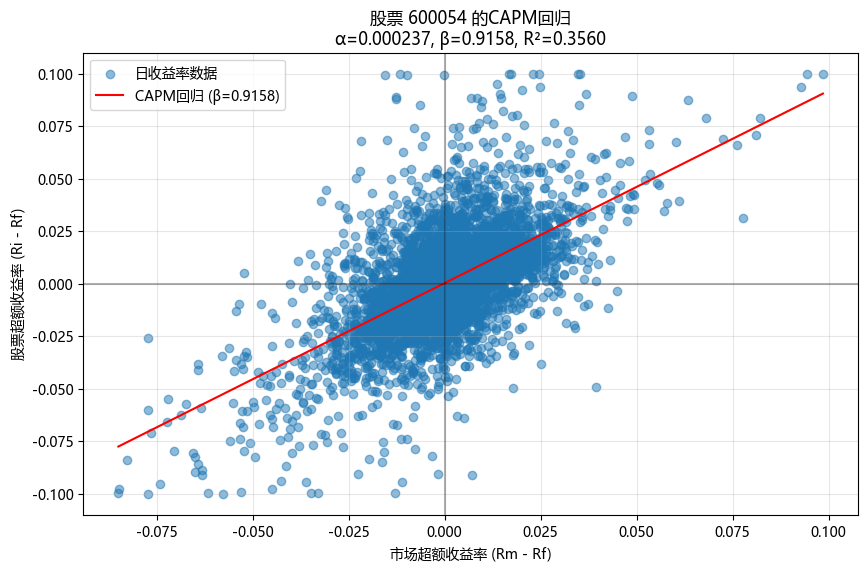

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

# 绘制回归图
def plot_capm_regression(results):
    # 提取模型和数据
    model = results["model"]
    X = model.model.exog  # 包含常数项和市场超额收益率
    Y = model.model.endog  # 股票超额收益率
    
    # 创建绘图
    plt.figure(figsize=(10, 6))
    
    # 散点图
    plt.scatter(X[:, 1], Y, alpha=0.5, label='日收益率数据')
    
    # 回归线
    x_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x_range_with_const = sm.add_constant(x_range)
    y_pred = model.predict(x_range_with_const)
    plt.plot(x_range, y_pred, 'r-', label=f'CAPM回归 (β={results["beta"]:.4f})')
    
    # 添加信息
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # 标题和标签
    plt.title(f'股票 {results["stock_code"]} 的CAPM回归\nα={results["alpha"]:.6f}, β={results["beta"]:.4f}, R²={results["r_squared"]:.4f}')
    plt.xlabel('市场超额收益率 (Rm - Rf)')
    plt.ylabel('股票超额收益率 (Ri - Rf)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.show()

plot_capm_regression(single_result)

In [8]:
# 多个一起检验
def test_all_stocks(stock_codes, market_index_path=None, risk_free_rate=None, 
                   base_dir="./assets/data/stock", start_date=None, end_date=None):
    # 只要加载一次市场指数，可以复用
    market_index_df = None

    # 对每个股票进行检验
    results = {}
    for code in stock_codes:
        print(f"正在检验股票 {code}...")
        stock_result = test_capm_time_series(
            code, market_index_df, risk_free_rate, 
            base_dir, start_date, end_date
        )
        results[code] = stock_result
        
        # 绘制图片
        plot_capm_regression(stock_result)
    
    return results

In [9]:
# 汇总结果
def summarize_results(results):
    summary = []
    
    for code, result in results.items():
        if "error" in result:
            row = {
                "股票代码": code,
                "错误": result["error"],
                "Alpha": None,
                "Beta": None,
                "R²": None,
                "CAPM是否成立": None
            }
        else:
            row = {
                "股票代码": code,
                "Alpha": result["alpha"],
                "Alpha P值": result["alpha_pvalue"],
                "Beta": result["beta"],
                "Beta P值": result["beta_pvalue"],
                "R²": result["r_squared"],
                "CAPM是否成立": result["capm_valid"],
                "异方差性": result["white_test"]["reject_homoscedasticity"],
                "残差非正态": result["jarque_bera_test"]["reject_normality"],
                "残差自相关": result["ljung_box_test"]["reject_no_autocorrelation"],
                "非线性关系": result["non_linearity"]["is_significant"]
            }
        summary.append(row)
        
    df = pd.DataFrame(summary)
    
    return df

正在检验股票 600054...


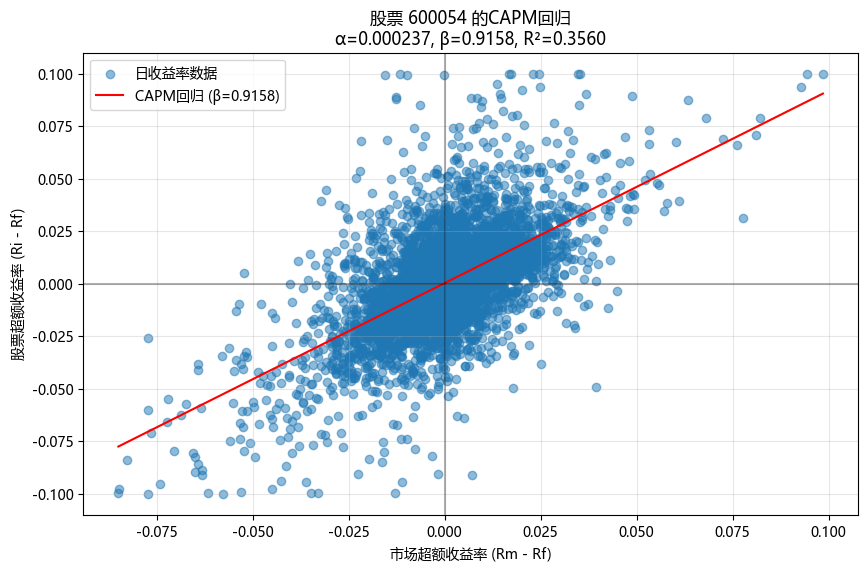

正在检验股票 600354...


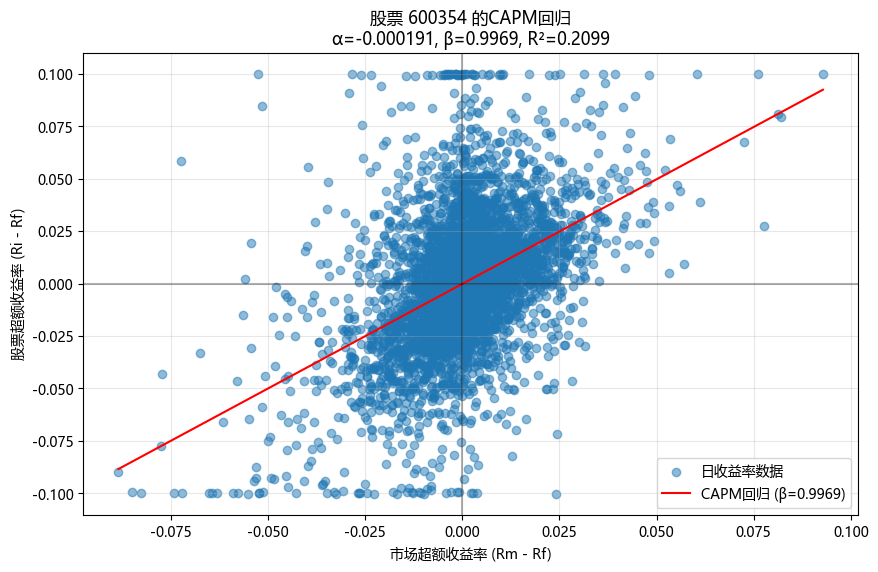

正在检验股票 600654...


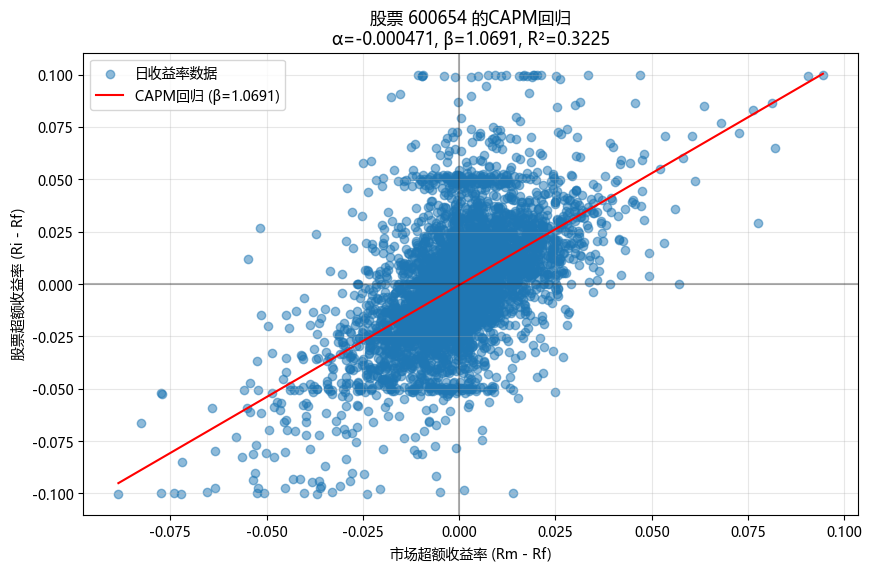

正在检验股票 600754...


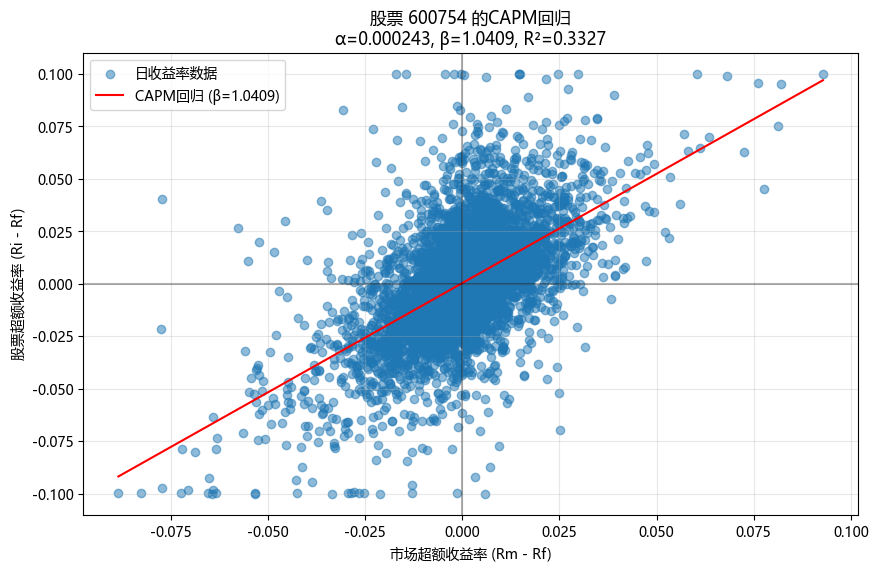

正在检验股票 600854...


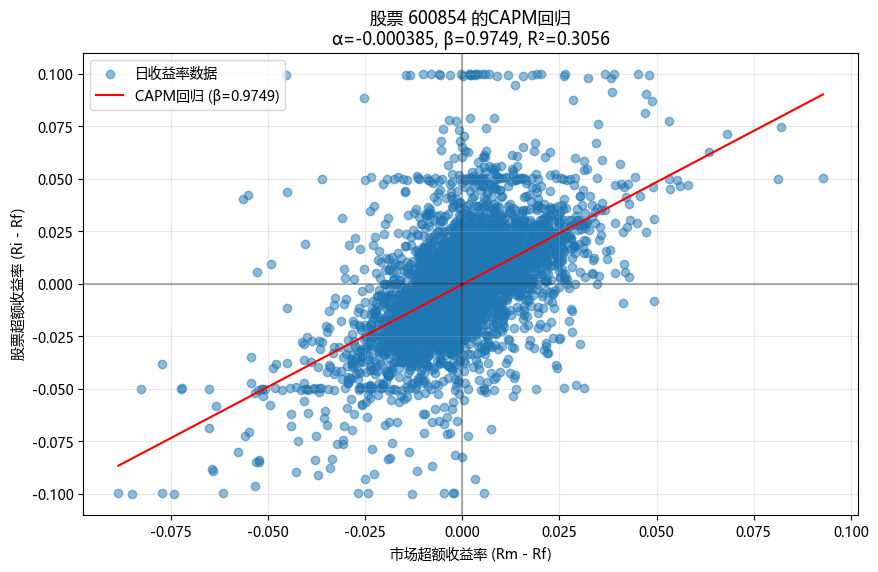

正在检验股票 000554...


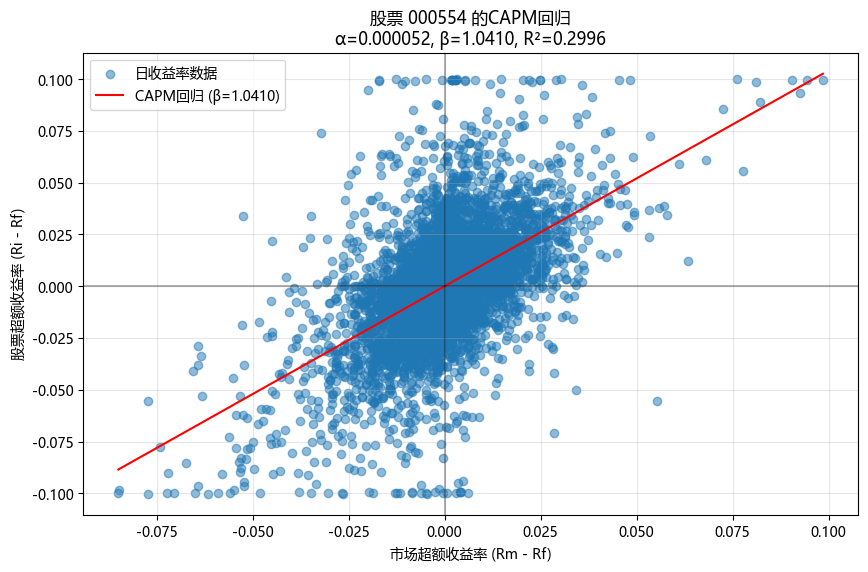

正在检验股票 002054...


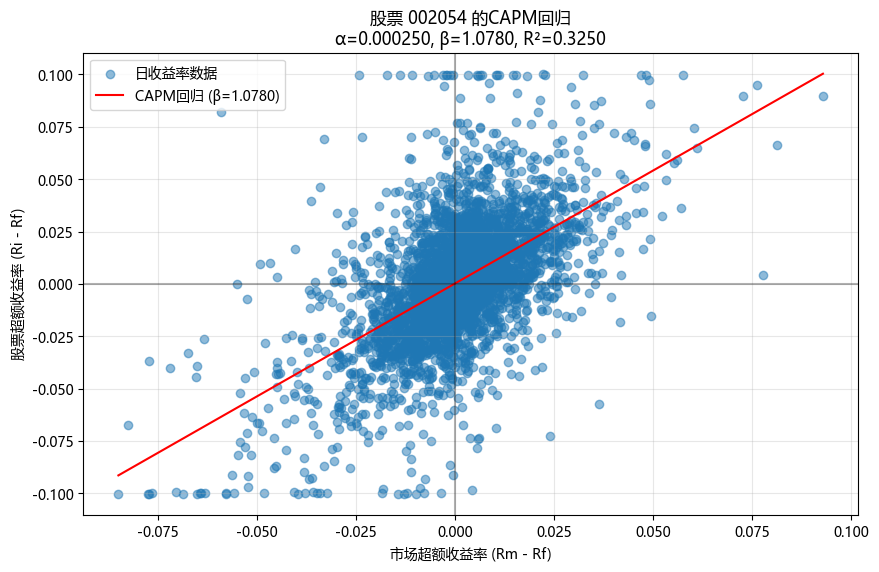

正在检验股票 002154...


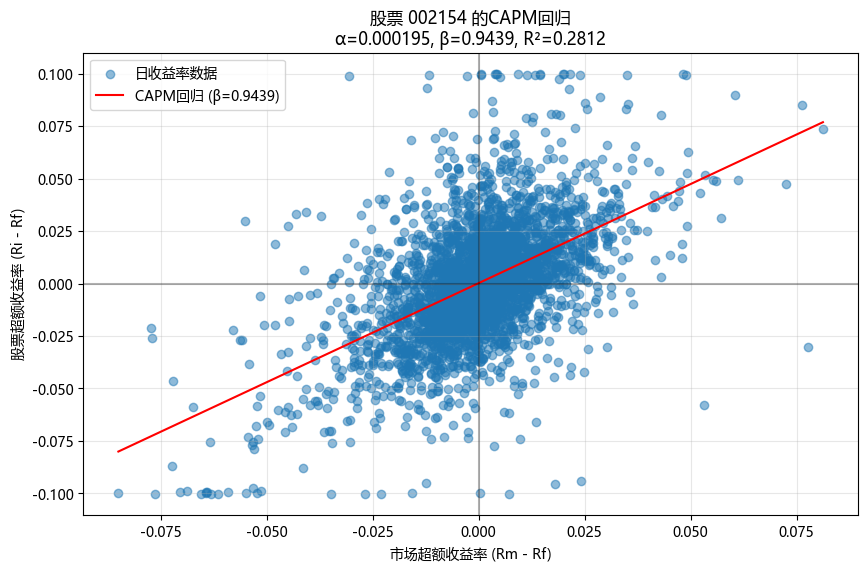

,股票代码,Alpha,Alpha P值,Beta,Beta P值,R²,CAPM是否成立,异方差性,残差非正态,残差自相关,非线性关系
0,600054,0.000237,0.337139,0.915826,0.000000e+00,0.355992,True,True,True,True,True
1,600354,-0.000191,0.658322,0.996877,6.773955e-227,0.209900,True,True,True,True,False
2,600654,-0.000471,0.141689,1.069081,0.000000e+00,0.322469,True,True,True,True,True
3,600754,0.000243,0.401964,1.040942,0.000000e+00,0.332724,True,True,True,True,False
4,600854,-0.000385,0.173864,0.974885,0.000000e+00,0.305619,True,True,True,True,True
5,000554,0.000052,0.869651,1.040979,0.000000e+00,0.299610,True,True,True,True,True
6,002054,0.000250,0.506489,1.078045,0.000000e+00,0.325020,True,True,True,True,True
7,002154,0.000195,0.595806,0.943878,3.966296e-266,0.281159,True,True,True,True,True


In [10]:
# 股票代码
stock_codes = ['600054', '600354', '600654', '600754', '600854', '000554', '002054', '002154']

# 测试时间范围
start_date = '2000-01-01'
end_date = '2022-12-31'

# 执行CAPM检验
all_results = test_all_stocks(
    stock_codes, 
    start_date=start_date, 
    end_date=end_date
)

# 汇总结果
summary_df = summarize_results(all_results)
summary_df

### 结果解读：

1. **Alpha值**：
   - 所有股票的Alpha值接近零，且p值均大于0.05，表明没有显著的超额收益

2. **Beta值**：
   - 所有股票Beta值接近1（0.94-1.08之间），且p值极小，表明与市场走势高度相关
   - Beta>1的股票（如600654、002054等）比市场略微波动性更大

3. **R²值**：
   - R²值在0.21-0.36之间，表明市场因素仅能解释这些股票21-36%的收益率变动
   - 其他非市场因素对这些股票影响较大

4. **模型检验**：
   - 尽管CAPM形式上成立（Alpha不显著），但几乎所有股票都存在异方差性、残差非正态和自相关问题
   - 大部分股票还存在非线性关系问题（6只为True，2只为False）

### 结论：
这些股票与大盘走势基本同步，没有显著异常回报。但统计检验问题表明，简单CAPM模型无法完全解释这些股票的收益模式，可能需要考虑更复杂的多因素模型。

## 利用股票月收益数据对CAPM模型做多资产时间序列检验

In [11]:
# 加载月度数据
def load_stock_monthly_data(stock_code, base_dir="./assets/data/stock"):
    monthly_path = os.path.join(base_dir, stock_code, "monthly", f"{stock_code}_monthly_returns.csv")
    
    # 读取月收益率数据
    df = pd.read_csv(monthly_path)
    
    # 将交易日期转换为datetime格式
    df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
    df = df.sort_values('trade_date')  # 按日期排序
    
    df = df.dropna()

    # 删除monthly_return大于0.5或小于-0.5的行
    df = df[(df['monthly_return'] >= -0.) & (df['monthly_return'] <= 0.5)]
        
    return df

test_df = load_stock_monthly_data('000554')
test_df

,ts_code,trade_date,year_month,open,close,high,low,vol,amount,first_day,last_day,monthly_return
0,000554.SZ,2000-01-01,200001,4.35,4.42,5.02,4.20,495956.00,2.275593e+05,20000104,20000128,0.000000
1,000554.SZ,2000-02-01,200002,4.43,4.87,5.28,4.43,730117.00,3.524337e+05,20000214,20000229,0.101810
2,000554.SZ,2000-03-01,200003,4.87,5.48,5.58,4.68,1323940.00,6.720840e+05,20000301,20000331,0.125257
3,000554.SZ,2000-04-01,200004,5.50,6.08,6.44,5.20,1748156.00,1.036279e+06,20000403,20000428,0.109489
4,000554.SZ,2000-05-01,200005,6.10,8.07,8.19,6.10,1686216.00,1.207961e+06,20000508,20000531,0.327303
...,...,...,...,...,...,...,...,...,...,...,...,...
264,000554.SZ,2022-02-01,202202,5.65,6.19,6.53,5.53,5400110.53,3.236588e+06,20220207,20220228,0.139963
267,000554.SZ,2022-05-01,202205,4.60,5.89,6.42,4.54,3728455.87,2.052676e+06,20220505,20220531,0.300221
269,000554.SZ,2022-07-01,202207,5.26,5.47,5.61,4.97,2418218.71,1.268595e+06,20220701,20220729,0.037951
270,000554.SZ,2022-08-01,202208,5.45,5.53,6.39,5.23,4624893.02,2.663975e+06,20220801,20220831,0.010969


In [12]:
# 月度指数我们采用手动计算的方式，因为只给了日度数据
def load_market_monthly_index(index_path="./assets/data/market/szzs_daily.xls"): 
    df = pd.read_excel(index_path)
    
    column_mapping = {
        '指数代码_IdxCd': 'index_code',
        '指数名称_IdxNm': 'index_name',
        '交易日期_TrdDt': 'trade_date',
        '收盘价(元/点)_ClPr': 'close',
        '涨跌幅(%)_ChgPct': 'daily_return_pct'
    }
    
    # 重命名存在的列
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
            
    # 检查日期格式，处理各种可能的格式
    date_sample = str(df['trade_date'].iloc[0])
    if '/' in date_sample or '-' in date_sample:
        df['trade_date'] = pd.to_datetime(df['trade_date'])
    else:
        df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
            
    # 按日期排序
    df = df.sort_values('trade_date')
    
    # 使用已有的涨跌幅数据，转换为小数
    if 'daily_return_pct' in df.columns:
        df['daily_return'] = df['daily_return_pct'] / 100
    else:
        # 如果没有涨跌幅列，则计算日收益率
        df['daily_return'] = df['close'].pct_change()
    
    df = df[(df['daily_return'] >= -0.1) & (df['daily_return'] <= 0.1)]
    
    # 提取年月信息用于分组
    df['year_month'] = df['trade_date'].dt.strftime('%Y-%m')
    
    # 计算月度收益率，每月最后一天收盘价相对上月最后一天收盘价的变化
    monthly_df = df.groupby('year_month').agg({
        'trade_date': 'last',     # 取每月最后一个交易日
        'close': 'last',          # 取月末收盘价
        'index_code': 'first',    # 保留指数代码
        'index_name': 'first'     # 保留指数名称
    }).reset_index()
    
    monthly_df['monthly_return'] = monthly_df['close'].pct_change()
    
    # 创建最终输出数据框
    result_df = monthly_df[['trade_date', 'index_code', 'index_name', 'close', 'monthly_return']].copy()
    
    result_df = result_df.dropna(subset=['monthly_return'])
    
    return result_df

load_market_monthly_index()

,trade_date,index_code,index_name,close,monthly_return
1,2000-02-29,1,上证指数,1714.5780,0.116991
2,2000-03-31,1,上证指数,1800.2250,0.049952
3,2000-04-28,1,上证指数,1836.3210,0.020051
4,2000-05-31,1,上证指数,1894.5540,0.031712
5,2000-06-30,1,上证指数,1928.1060,0.017710
...,...,...,...,...,...
271,2022-08-31,1,上证指数,3202.1378,-0.015708
272,2022-09-30,1,上证指数,3024.3905,-0.055509
273,2022-10-31,1,上证指数,2893.4829,-0.043284
274,2022-11-30,1,上证指数,3151.3353,0.089115


In [13]:
# 月度无风险收益率
def calculate_monthly_risk_free_rate(treasury_bill_path="./assets/data/rf_monthly.xls"):
    # 读取Excel文件
    df = pd.read_excel(treasury_bill_path)
    
    # 统一列名
    column_renames = {'日期_Date': 'date', '月无风险收益率_MonRFRet': 'rf_rate'}
    df.rename(columns=column_renames, inplace=True)
    
    
    # 格式化日期列
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    return df

calculate_monthly_risk_free_rate()

,date,rf_rate
0,2000-01-01,0.001650
1,2000-02-01,0.001650
2,2000-03-01,0.001650
3,2000-04-01,0.001650
4,2000-05-01,0.001650
...,...,...
271,2022-08-01,0.001366
272,2022-09-01,0.001342
273,2022-10-01,0.001413
274,2022-11-01,0.001676


In [21]:
def prepare_panel_data(stock_codes, base_dir, start_date=None, end_date=None, fill_method='ffill'):
    """
    加载所有数据
    
    参数:
    stock_codes (list): 股票代码列表
    base_dir (str): 数据存储的基础目录
    start_date (str): 开始日期，格式为'YYYY-MM-DD'
    end_date (str): 结束日期，格式为'YYYY-MM-DD'
    fill_method (str): 缺失值填充方法，'ffill'表示前向填充，'mean'表示均值填充，None表示不填充
    
    返回:
    tuple: (基础面板数据, 股票数据字典, 有效股票代码列表)
    """
    # 日期筛选条件
    if start_date:
        start_date = pd.to_datetime(start_date)
    if end_date:
        end_date = pd.to_datetime(end_date)
    
    # 1. 收集所有可能出现的年月
    all_months = set()
    
    # 2. 加载市场数据
    market_df = load_market_monthly_index()
    market_df['year_month'] = market_df['trade_date'].dt.strftime('%Y-%m')
    
    if start_date:
        market_df = market_df[market_df['trade_date'] >= start_date]
    if end_date:
        market_df = market_df[market_df['trade_date'] <= end_date]
    
    all_months.update(market_df['year_month'])
    
    # 3. 加载无风险利率数据
    risk_free_df = calculate_monthly_risk_free_rate()
    if 'date' in risk_free_df.columns:
        risk_free_df['date'] = pd.to_datetime(risk_free_df['date'])
        risk_free_df = risk_free_df.rename(columns={'date': 'trade_date'})
    
    risk_free_df['year_month'] = risk_free_df['trade_date'].dt.strftime('%Y-%m')

    
    # 4. 加载每只股票数据
    stock_data_dict = {}
    
    for code in stock_codes:
        stock_df = load_stock_monthly_data(code, base_dir)
                
        # 处理缺失值
        stock_df['trade_date'] = pd.to_datetime(stock_df['trade_date'])
        stock_df['year_month'] = stock_df['trade_date'].dt.strftime('%Y-%m')
            
        if start_date:
            stock_df = stock_df[stock_df['trade_date'] >= start_date]
        if end_date:
            stock_df = stock_df[stock_df['trade_date'] <= end_date]
                
        # 收集年月
        all_months.update(stock_df['year_month'])
            
        # 保存股票数据
        stock_data_dict[code] = stock_df
    
    # 5. 创建基础面板数据框
    all_months = sorted(list(all_months))
    panel_data = pd.DataFrame({'year_month': all_months})
    
    # 6. 合并市场收益率
    market_data = market_df[['year_month', 'monthly_return']].rename(columns={'monthly_return': 'market_return'})
    panel_data = pd.merge(panel_data, market_data, on='year_month', how='left')
    
    # 7. 合并无风险利率
    panel_data = pd.merge(panel_data, risk_free_df[['year_month', 'rf_rate']], on='year_month', how='left')
    
    # 8. 填充缺失的市场数据和无风险利率
    if fill_method:
        # 填充市场收益率
        if panel_data['market_return'].isna().any():
            if fill_method == 'ffill':
                panel_data['market_return'] = panel_data['market_return'].fillna(method='ffill')
                panel_data['market_return'] = panel_data['market_return'].fillna(method='bfill')
            elif fill_method == 'mean':
                mean_market = panel_data['market_return'].mean()
                panel_data['market_return'] = panel_data['market_return'].fillna(mean_market)
        
        # 填充无风险利率
        if panel_data['rf_rate'].isna().any():
            if fill_method == 'ffill':
                panel_data['rf_rate'] = panel_data['rf_rate'].fillna(method='ffill')
                panel_data['rf_rate'] = panel_data['rf_rate'].fillna(method='bfill')
            elif fill_method == 'mean':
                mean_rf = panel_data['rf_rate'].mean()
                panel_data['rf_rate'] = panel_data['rf_rate'].fillna(mean_rf)
    
    # 检查利率列是否完整
    if panel_data['market_return'].isna().any() or panel_data['rf_rate'].isna().any():
        print("警告: 市场收益率或无风险利率存在缺失值")
        # 删除有缺失的行
        panel_data = panel_data.dropna(subset=['market_return', 'rf_rate'])
        print(f"删除缺失值后的数据形状: {panel_data.shape}")
    
    # 识别有效的股票代码
    valid_stocks = list(stock_data_dict.keys())
    
    return panel_data, stock_data_dict, valid_stocks

In [33]:
from scipy.stats import chi2

# CAPM联合检验
def perform_joint_tests(panel_data, stock_data_dict, valid_stocks, fill_method='ffill'):
    # 使用所有可能的年月，使用外连接，交集会导致数据集非常少
    all_stock_months = set()
    
    for code in valid_stocks:
        stock_df = stock_data_dict[code]
        months = set(stock_df['year_month'])
        all_stock_months.update(months)
    
    # 创建包含所有月份的面板
    common_panel = panel_data[panel_data['year_month'].isin(all_stock_months)].copy()
    
    # 为每只股票添加收益率，使用左连接
    for code in valid_stocks:
        stock_df = stock_data_dict[code]
        stock_returns = stock_df[['year_month', 'monthly_return']].copy()
        stock_returns = stock_returns.rename(columns={'monthly_return': f'return_{code}'})
        common_panel = pd.merge(common_panel, stock_returns, on='year_month', how='left')
    
    # 填充缺失的股票收益率数据
    for code in valid_stocks:
        if common_panel[f'return_{code}'].isna().any():
            if fill_method == 'ffill':
                common_panel[f'return_{code}'] = common_panel[f'return_{code}'].fillna(method='ffill')
                common_panel[f'return_{code}'] = common_panel[f'return_{code}'].fillna(method='bfill')
            elif fill_method == 'mean':
                mean_return = common_panel[f'return_{code}'].mean(skipna=True)
                common_panel[f'return_{code}'] = common_panel[f'return_{code}'].fillna(mean_return)
            else:
                # 如果没有指定填充方法，使用全局均值
                mean_return = stock_data_dict[code]['monthly_return'].mean()
                common_panel[f'return_{code}'] = common_panel[f'return_{code}'].fillna(mean_return)
            
        # 计算超额收益率
        common_panel[f'excess_return_{code}'] = common_panel[f'return_{code}'] - common_panel['rf_rate']
    
    # 计算市场超额收益率
    common_panel['excess_market_return'] = common_panel['market_return'] - common_panel['rf_rate']
    
    # 删除市场和无风险利率缺失的行
    common_panel = common_panel.dropna(subset=['market_return', 'rf_rate'])
    
    # 残差矩阵
    N = len(valid_stocks)
    resid_matrix = np.zeros((len(common_panel), N))
    alpha_hat_common = np.zeros(N)
    beta_hat_common = np.zeros(N)
    
    # 对每只股票进行回归，保存残差
    for i, code in enumerate(valid_stocks):
        y = common_panel[f'excess_return_{code}'].values
        X = sm.add_constant(common_panel['excess_market_return'].values)
        
        model = sm.OLS(y, X).fit()
        
        alpha_hat_common[i] = model.params[0]
        beta_hat_common[i] = model.params[1]
        resid_matrix[:, i] = model.resid
    
    # 计算残差协方差矩阵
    sigma_hat = np.dot(resid_matrix.T, resid_matrix) / len(common_panel)
    
    # Wald检验
    mu_market = np.mean(common_panel['excess_market_return'])
    sigma_market = np.var(common_panel['excess_market_return'])
    
    wald_stat = (len(common_panel) - N - 1) / N * (1 + mu_market**2 / sigma_market) * \
                np.dot(np.dot(alpha_hat_common, np.linalg.inv(sigma_hat)), alpha_hat_common)
    
    wald_pvalue = 1 - chi2.cdf(wald_stat, N)
    
    # 似然比检验
    log_L_unrestricted = -len(common_panel)/2 * (N * np.log(2*np.pi) + np.log(np.linalg.det(sigma_hat)) + N)
    
    # 约束模型（α=0）
    restricted_resid_matrix = np.zeros((len(common_panel), N))
    for i, code in enumerate(valid_stocks):
        y = common_panel[f'excess_return_{code}'].values
        X = common_panel['excess_market_return'].values.reshape(-1, 1)
        
        beta_restricted = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
        y_pred = np.dot(X, beta_restricted)
        restricted_resid_matrix[:, i] = y - y_pred
    
    sigma_hat_restricted = np.dot(restricted_resid_matrix.T, restricted_resid_matrix) / len(common_panel)
    
    log_L_restricted = -len(common_panel)/2 * (N * np.log(2*np.pi) + np.log(np.linalg.det(sigma_hat_restricted)) + N)
    
    lr_stat = -2 * (log_L_restricted - log_L_unrestricted)
    
    lr_pvalue = 1 - chi2.cdf(lr_stat, N)
    
    # 拉格朗日乘子检验
    T = len(common_panel)  # 样本量
    lm_stat = 0
    
    # 为每个股票执行辅助回归
    for i, code in enumerate(valid_stocks):
        # 获取约束模型(Alpha=0)的残差
        y_resid = restricted_resid_matrix[:, i]
        
        # 创建包含常数项的设计矩阵
        X_aux = sm.add_constant(common_panel['excess_market_return'].values)
        
        # 将残差对常数和市场超额收益率进行回归
        aux_model = sm.OLS(y_resid, X_aux).fit()
        
        # 计算辅助回归的R^2
        r_squared = aux_model.rsquared
        
        # 计算每个资产的LM统计量并累加
        lm_stat += T * r_squared
    
    # 计算LM p值
    lm_pvalue = 1 - chi2.cdf(lm_stat, N)
    
    # 联合检验结果
    joint_tests = {
        'wald_test': {
            'statistic': float(wald_stat),
            'pvalue': float(wald_pvalue),
            'reject_null': float(wald_pvalue) < 0.05
        },
        'lr_test': {
            'statistic': float(lr_stat),
            'pvalue': float(lr_pvalue),
            'reject_null': float(lr_pvalue) < 0.05
        },
        'lm_test': {
            'statistic': float(lm_stat),
            'pvalue': float(lm_pvalue),
            'reject_null': float(lm_pvalue) < 0.05
        },
        'common_sample_size': len(common_panel),
        'alpha_hat': alpha_hat_common.tolist(),
        'beta_hat': beta_hat_common.tolist()
    }
    
    return joint_tests

In [34]:
# 画图
def plot_joint_tests_results(joint_tests, valid_stocks):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. 联合检验结果
    test_names = []
    stats = []
    pvalues = []
    
    for test_name, test_info in joint_tests.items():
        if test_name not in ['error', 'common_sample_size', 'alpha_hat', 'beta_hat'] and isinstance(test_info, dict) and 'statistic' in test_info:
            test_names.append(test_name)
            stats.append(test_info['statistic'])
            pvalues.append(test_info['pvalue'])
    
    if test_names:
        bar_colors = ['green' if p > 0.05 else 'red' for p in pvalues]
        bars = axes[0].bar(test_names, stats, alpha=0.7, color=bar_colors)
        
        for i, p in enumerate(pvalues):
            axes[0].text(i, stats[i] + 0.1, f'p={p:.4f}', ha='center')
        
        axes[0].set_xlabel('检验方法')
        axes[0].set_ylabel('统计量')
        axes[0].set_title('联合检验结果 (绿色=不拒绝，红色=拒绝)')
        axes[0].grid(True, alpha=0.3)
    
    # 2. Alpha值散点图
    if 'alpha_hat' in joint_tests and 'beta_hat' in joint_tests:
        alphas = joint_tests['alpha_hat']
        betas = joint_tests['beta_hat']
        
        axes[1].scatter(betas, alphas, alpha=0.7, s=80)
        for i, code in enumerate(valid_stocks):
            axes[1].annotate(code, (betas[i], alphas[i]), fontsize=10)
        
        axes[1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
        axes[1].set_xlabel('Beta')
        axes[1].set_ylabel('Alpha')
        axes[1].set_title('Alpha vs Beta')
        axes[1].grid(True, alpha=0.3)
    
    # 整体标题
    plt.suptitle('CAPM多资产联合检验结果', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig

In [35]:
# 解释检验结果
def interpret_joint_tests(joint_tests, valid_stocks):
    interpretations = []
    
    if isinstance(joint_tests, dict) and 'error' not in joint_tests:
        # 检查是否所有测试都不拒绝原假设
        all_tests_agree = True
        any_test_rejects = False
        
        for test_name, test_results in joint_tests.items():
            # 跳过非测试结果的键
            if test_name in ['error', 'common_sample_size', 'alpha_hat', 'beta_hat']:
                continue
                
            # 确保test_results是字典而不是整数或其他类型
            if isinstance(test_results, dict) and 'reject_null' in test_results:
                if test_results['reject_null']:
                    any_test_rejects = True
                    all_tests_agree = False
            else:
                all_tests_agree = False
        
        if all_tests_agree and not any_test_rejects:
            interpretations.append("所有联合检验（Wald、LR、LM）均不拒绝原假设，表明CAPM模型在联合检验下成立。")
            interpretations.append("所有股票的Alpha值联合为零，符合CAPM模型的预期。")
            capm_valid = True
        elif any_test_rejects:
            rejection_tests = []
            for test_name, test_results in joint_tests.items():
                # 确保test_results是字典并且包含reject_null键
                if test_name not in ['error', 'common_sample_size', 'alpha_hat', 'beta_hat'] and isinstance(test_results, dict) and 'reject_null' in test_results and test_results['reject_null']:
                    rejection_tests.append(test_name)
            
            if rejection_tests:
                interpretations.append(f"以下检验拒绝原假设：{', '.join(rejection_tests)}，表明CAPM模型在联合检验下不成立。")
                interpretations.append("至少有部分股票存在非零Alpha值，不符合CAPM模型的预期。")
                capm_valid = False
            else:
                interpretations.append("联合检验结果不一致，部分检验支持CAPM模型，部分检验不支持。")
                capm_valid = None
        else:
            interpretations.append("联合检验未给出明确结论。")
            capm_valid = None
    else:
        interpretations.append("未能进行联合检验。")
        capm_valid = None
    
    return interpretations, capm_valid

In [36]:
def test_capm_joint(stock_codes, base_dir="./assets/data/stock", start_date=None, end_date=None, fill_method='ffill'):
    # 1. 准备面板数据
    panel_data, stock_data_dict, valid_stocks = prepare_panel_data(
        stock_codes=stock_codes,
        base_dir=base_dir,
        start_date=start_date,
        end_date=end_date,
        fill_method=fill_method
    )
    
    # 2. 直接进行联合检验
    joint_tests = perform_joint_tests(
        panel_data=panel_data,
        stock_data_dict=stock_data_dict,
        valid_stocks=valid_stocks,
        fill_method=fill_method
    )
    
    # 3. 解释结果
    interpretations, capm_valid = interpret_joint_tests(
        joint_tests=joint_tests,
        valid_stocks=valid_stocks
    )
    
    # 4. 返回结果
    return {
        'stock_codes': valid_stocks,
        'joint_tests': joint_tests,
        'interpretations': interpretations,
        'capm_valid': capm_valid
    }

In [37]:
# 完整流程
def run_capm_joint_analysis(stock_codes, start_date=None, end_date=None, base_dir="./assets/data/stock"):
    print("\n====== CAPM联合检验分析 ======")
    print(f"分析股票: {', '.join(stock_codes)}")
    print(f"日期范围: {start_date or '所有'} 到 {end_date or '所有'}")
    print("================================\n")
    
    # 1. 进行CAPM联合检验
    results = test_capm_joint(
        stock_codes=stock_codes,
        base_dir=base_dir,
        start_date=start_date,
        end_date=end_date,
        fill_method='ffill'
    )
    
    # 检查是否有错误
    if 'error' in results:
        print(f"\n错误: {results['error']}")
        return results
    
    # 2. 打印结果
    print("\n=== 联合检验结果 ===")
    if 'joint_tests' in results and isinstance(results['joint_tests'], dict) and 'error' not in results['joint_tests']:
        for test_name, test_info in results['joint_tests'].items():
            if test_name not in ['error', 'common_sample_size', 'alpha_hat', 'beta_hat'] and isinstance(test_info, dict) and 'statistic' in test_info:
                print(f"{test_name}: 统计量 = {test_info['statistic']:.4f}, P值 = {test_info['pvalue']:.4f}, 拒绝原假设: {test_info['reject_null']}")
    else:
        print("无法进行联合检验")
    
    print("\n=== 解释 ===")
    for interp in results['interpretations']:
        print(f"- {interp}")
    
    capm_valid = results.get('capm_valid')
    if capm_valid is not None:
        print(f"\nCAPM模型是否成立: {'是' if capm_valid else '否'}")
    else:
        print("\nCAPM模型是否成立: 无法确定")
    
    # 3. 绘制图形
    fig = plot_joint_tests_results(
        joint_tests=results['joint_tests'],
        valid_stocks=results['stock_codes']
    )
    
    # 4. 返回结果
    return {
        'results': results,
        'figure': fig
    }


====== CAPM联合检验分析 ======
分析股票: 600054, 600354, 600654, 600754, 600854, 000554, 002054, 002154
日期范围: 2000-01-01 到 2022-12-31


=== 联合检验结果 ===
wald_test: 统计量 = 113.4335, P值 = 0.0000, 拒绝原假设: True
lr_test: 统计量 = 366.0917, P值 = 0.0000, 拒绝原假设: True
lm_test: 统计量 = 82.4018, P值 = 0.0000, 拒绝原假设: True

=== 解释 ===
- 以下检验拒绝原假设：wald_test, lr_test, lm_test，表明CAPM模型在联合检验下不成立。
- 至少有部分股票存在非零Alpha值，不符合CAPM模型的预期。

CAPM模型是否成立: 否


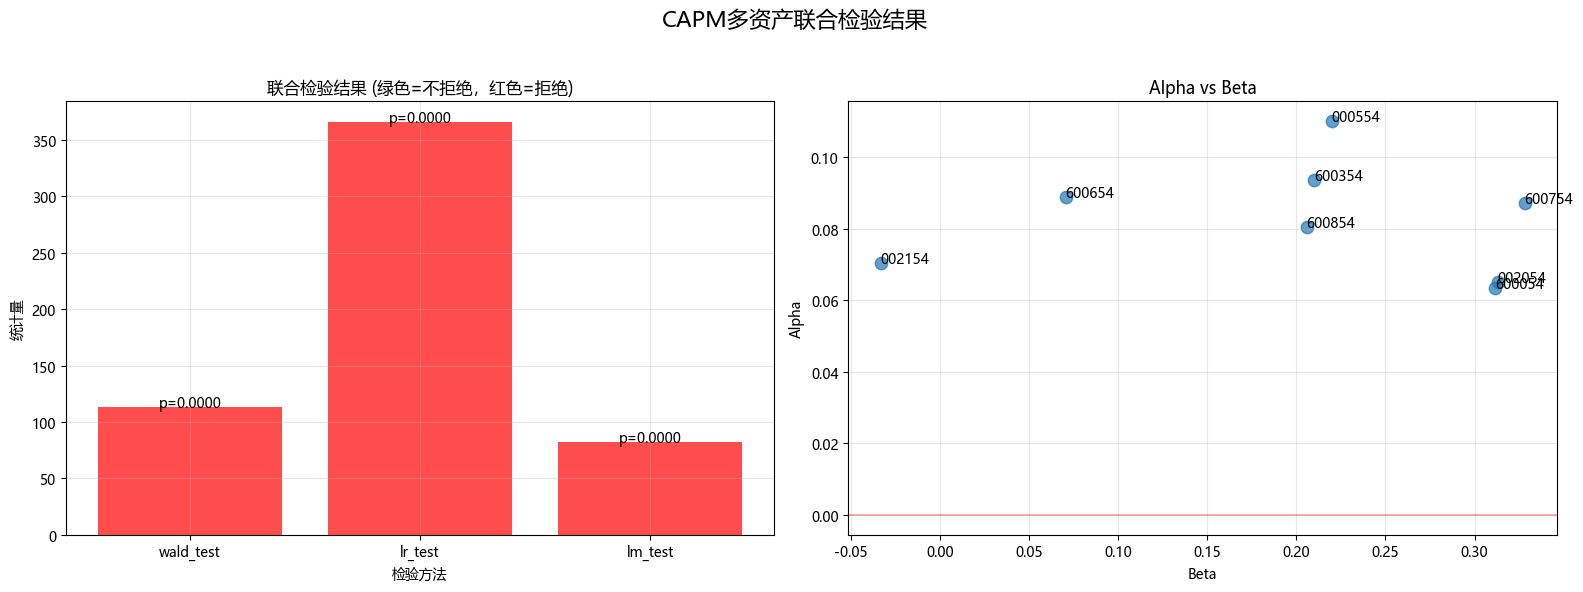

In [38]:
stock_codes = ['600054', '600354', '600654', '600754', '600854', '000554', '002054', '002154']
start_date = '2000-01-01'
end_date = '2022-12-31'

# 运行分析
analysis_results = run_capm_joint_analysis(
    stock_codes=stock_codes,
    start_date=start_date,
    end_date=end_date
)

### CAPM联合检验分析简要总结

三种检验方法（Wald、LR和LM）一致拒绝"所有股票Alpha值共同为零"的原假设：

- Wald检验：统计量=113.4335，P值=0.0000
- LR检验：统计量=366.0917，P值=0.0000
- LM检验：统计量=82.4018，P值=0.0000

主要结论：

1. CAPM模型在解释所分析的8只中国股票（600054、600354等）收益率方面不成立
2. 所有股票均显示出正的Alpha值，表明它们产生了CAPM模型无法解释的超额收益
3. 这暗示市场风险溢价（单一因素）不足以解释这些股票的表现，应考虑采用多因素模型

### 单资产vs多资产检验的差异

1. **检验角度不同**：
   - **单资产检验**：单独检验每只股票的Alpha是否显著不为零，着重于个体显著性
   - **多资产联合检验**：检验所有股票的Alpha是否共同为零，考虑了股票间的相关性

2. **统计效力不同**：
   - 多资产联合检验通常具有更高的统计效力，能发现单资产检验可能忽略的效应
   - 当样本中有多只股票共同表现出微弱但一致的Alpha时，单独看可能不显著，但联合起来可能非常显著

从表格中可以看到：

- 大多数股票的Alpha值虽然不为零，但P值较大（如600054的Alpha P值为0.337139），表明在单资产检验中这些Alpha不显著
- 这就是为什么单资产检验显示"CAPM是否成立: True"
- 然而，当使用Wald、LR和LM联合检验时，考虑到所有股票Alpha的整体模式及其相关性，结果显示这些Alpha共同显著不为零

### 为什么会出现这种情况

1. **相关性影响**：股票收益之间可能存在显著相关性，联合检验考虑了这种相关性
2. **样本量影响**：联合检验使用更多数据点，提高了统计效力
3. **小效应累积**：多只股票的小效应累积起来可能导致显著的整体效应

总结：单资产检验和联合检验结果不一致是正常的现象，反映了两种方法的不同统计特性。联合检验结果通常更可靠，因为它考虑了资产间的相关性并具有更高的统计效力。这也说明中国股票市场上的CAPM模型局限性可能比单独看每只股票时显得更为明显。

## 市场效应实证检验

我们在锐思数据库下载A股2000-01-01~2022-12-31的月度所有股票数据。其中，一共有747758条数据，但是我们只有下100000条数据的权限。

In [39]:
def load_and_prepare_data(file_path1, file_path2):
    # 加载数据文件
    df1 = pd.read_excel(file_path1)
    df2 = pd.read_excel(file_path2)
    
    # 合并数据
    df = pd.concat([df1, df2], ignore_index=True)
    
    # 重命名列以匹配代码中使用的列名
    df = df.rename(columns={
        '股票代码_Stkcd': 'Stkcd',
        '日期_Date': 'Date',
        '月收益率_Monret': 'Monret'
    })
    
    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 按股票代码和日期排序
    df = df.sort_values(['Stkcd', 'Date'])
    
    # 处理缺失值
    df['Monret'] = df['Monret'].fillna(method='ffill')
    
    print(f"数据加载完成: {len(df)} 行, {df['Stkcd'].nunique()} 只股票")
    
    return df

In [51]:
# 累积收益率计算
def calculate_cumulative_returns(df, formation_period):
    # 获取排序后的唯一日期
    dates = sorted(df['Date'].unique())
    
    # 预先创建结果容器，避免动态增长
    result_list = []
    
    # 预先创建所有股票代码列表
    stocks = df['Stkcd'].unique()
    
    # 使用日期索引加速查找
    date_to_idx = {date: i for i, date in enumerate(dates)}
    
    # 为每个日期创建一个股票数据查找字典，减少重复过滤
    stock_date_data = {}
    for stock in stocks:
        stock_df = df[df['Stkcd'] == stock]
        stock_date_data[stock] = {d: group for d, group in stock_df.groupby('Date')}
    
    # 优化循环
    for i in range(formation_period, len(dates)):
        current_date = dates[i]
        start_date = dates[i - formation_period]
        
        for stock in stocks:
            # 检查是否有足够的数据
            date_range = [d for d in dates[i-formation_period:i+1] if d in stock_date_data[stock]]
            if len(date_range) < formation_period * 0.8:
                continue
            
            # 计算累积收益率
            cum_return = 1.0
            for d in date_range:
                if d in stock_date_data[stock]:
                    ret = stock_date_data[stock][d]['Monret'].values[0]
                    cum_return *= (1 + ret)
            cum_return -= 1
            
            result_list.append({
                'Stkcd': stock,
                'FormationEnd': current_date,
                'CumReturn': cum_return
            })
    
    return pd.DataFrame(result_list)

In [41]:
def construct_portfolios(cum_returns_df, num_portfolios=5):
    """
    基于累积收益率构建投资组合
    
    参数:
    cum_returns_df: 包含累积收益率的DataFrame
    num_portfolios: 投资组合数量
    
    返回:
    portfolio_assignments: 包含每只股票所属投资组合的DataFrame
    """
    # 创建一个空的DataFrame存储结果
    portfolio_assignments = []
    
    # 获取唯一的形成期结束日期
    formation_dates = cum_returns_df['FormationEnd'].unique()
    
    # 对于每个形成期结束日期
    for date in formation_dates:
        # 获取这个日期的所有股票
        date_data = cum_returns_df[cum_returns_df['FormationEnd'] == date]
        
        # 如果股票数量不足，跳过这个日期
        if len(date_data) < num_portfolios:
            continue
            
        # 按累积收益率排序
        date_data = date_data.sort_values('CumReturn')
        
        # 计算每个投资组合应包含的股票数量
        stocks_per_portfolio = len(date_data) // num_portfolios
        remainder = len(date_data) % num_portfolios
        
        # 分配股票到投资组合
        for i, row in enumerate(date_data.itertuples()):
            portfolio = i // stocks_per_portfolio
            # 确保不超过投资组合数量
            if portfolio >= num_portfolios:
                portfolio = num_portfolios - 1
                
            portfolio_assignments.append({
                'Stkcd': row.Stkcd,
                'FormationEnd': date,
                'Portfolio': f'P{portfolio+1}'
            })
    
    return pd.DataFrame(portfolio_assignments)

In [56]:
def calculate_holding_returns(df, portfolio_assignments, holding_period):
    """
    计算各投资组合在持有期内的收益率
    
    参数:
    df: 原始收益率数据
    portfolio_assignments: 投资组合分配
    holding_period: 持有期长度（月）
    
    返回:
    holding_returns: 包含持有期收益率的DataFrame
    """
    # 创建一个空的DataFrame存储结果
    holding_returns = []
    
    # 获取唯一的形成期结束日期
    formation_dates = portfolio_assignments['FormationEnd'].unique()
    dates = sorted(df['Date'].unique())
    
    print(f"形成期结束日期数量: {len(formation_dates)}")
    print(f"总日期数量: {len(dates)}")
    
    # 对于每个形成期结束日期
    for formation_date in formation_dates:
        # 找到形成期结束日期在dates中的索引
        try:
            date_index = next((i for i, d in enumerate(dates) if d >= formation_date), None)
            if date_index is None:
                continue
        except:
            continue
        
        # 找到尽可能接近holding_period个月后的日期
        end_index = min(date_index + holding_period, len(dates) - 1)
        holding_end_date = dates[end_index]
        
        # 获取分配给每个投资组合的股票
        portfolios = portfolio_assignments[portfolio_assignments['FormationEnd'] == formation_date]
        
        if len(portfolios) == 0:
            continue
        
        # 对于每个投资组合
        for portfolio in portfolios['Portfolio'].unique():
            # 获取投资组合内的股票
            stocks = portfolios[portfolios['Portfolio'] == portfolio]['Stkcd'].tolist()
            
            # 计算这些股票在持有期内的平均收益率
            portfolio_returns = []
            
            for stock in stocks:
                # 获取这只股票在持有期内的数据
                stock_data = df[(df['Stkcd'] == stock) & 
                                (df['Date'] > formation_date) & 
                                (df['Date'] <= holding_end_date)]
                
                # 放宽条件：只要有一些数据点就计算收益率
                # 之前可能要求至少有holding_period * 0.8个数据点
                if len(stock_data) > 0:  # 只要有数据就计算
                    # 计算持有期累积收益率
                    cum_return = (1 + stock_data['Monret']).prod() - 1
                    portfolio_returns.append(cum_return)
            
            # 放宽条件：只要有一些股票数据就计算组合收益率
            if len(portfolio_returns) > 0:  # 之前可能有更高的要求
                # 计算投资组合平均收益率
                avg_return = np.mean(portfolio_returns)
                
                holding_returns.append({
                    'FormationEnd': formation_date,
                    'HoldingEnd': holding_end_date,
                    'Portfolio': portfolio,
                    'HoldingPeriod': holding_period,
                    'ReturnAvg': avg_return,
                    'StocksWithData': len(portfolio_returns)  # 添加有数据的股票数量
                })
    
    result_df = pd.DataFrame(holding_returns)
    print(f"持有期 {holding_period} 月的收益率记录数: {len(result_df)}")
    return result_df

In [43]:
def test_momentum_reversal(holding_returns):
    """
    检验是否存在惯性效应或反转效应
    
    参数:
    holding_returns: 持有期收益率数据
    
    返回:
    results: 包含检验结果的DataFrame
    """
    # 创建一个空的DataFrame存储结果
    results = []
    
    # 获取唯一的持有期长度
    holding_periods = holding_returns['HoldingPeriod'].unique()
    
    # 对于每个持有期长度
    for period in holding_periods:
        # 筛选这个持有期的数据
        period_data = holding_returns[holding_returns['HoldingPeriod'] == period]
        
        # 为每个形成期结束日期，计算P5-P1的差异
        formation_dates = period_data['FormationEnd'].unique()
        
        differences = []
        
        for date in formation_dates:
            date_data = period_data[period_data['FormationEnd'] == date]
            
            # 如果没有P1或P5，跳过这个日期
            if 'P1' not in date_data['Portfolio'].values or 'P5' not in date_data['Portfolio'].values:
                continue
                
            p1_return = date_data[date_data['Portfolio'] == 'P1']['ReturnAvg'].values[0]
            p5_return = date_data[date_data['Portfolio'] == 'P5']['ReturnAvg'].values[0]
            
            difference = p5_return - p1_return
            differences.append(difference)
        
        # 如果没有足够的数据点，跳过这个持有期
        if len(differences) < 2:
            continue
            
        # 执行t检验
        t_stat, p_value = stats.ttest_1samp(differences, 0)
        
        # 判断效应类型
        if p_value < 0.05:
            if np.mean(differences) > 0:
                effect_type = "Momentum (惯性效应)"
            else:
                effect_type = "Reversal (反转效应)"
        else:
            effect_type = "No significant effect (无显著效应)"
        
        results.append({
            'HoldingPeriod': period,
            'EffectType': effect_type,
            'MeanDifference': np.mean(differences),
            'tStatistic': t_stat,
            'pValue': p_value
        })
    
    return pd.DataFrame(results)


In [58]:
def visualize_results(holding_returns, test_results):
    """
    可视化分析结果
    
    参数:
    holding_returns: 持有期收益率数据
    test_results: 检验结果数据
    """
    # 检查holding_returns是否有数据
    if len(holding_returns) == 0:
        print("警告: 没有可用的持有期收益率数据，跳过可视化")
        return
        
    # 绘制不同投资组合的平均收益率
    try:
        plt.figure(figsize=(12, 6))
        
        # 获取唯一的持有期长度
        holding_periods = holding_returns['HoldingPeriod'].unique()
        
        for period in holding_periods:
            # 筛选这个持有期的数据
            period_data = holding_returns[holding_returns['HoldingPeriod'] == period]
            
            # 计算每个投资组合的平均收益率
            portfolio_avg = period_data.groupby('Portfolio')['ReturnAvg'].mean().reset_index()
            
            # 确保按照P1到P5的顺序排序
            portfolio_avg['PortfolioNum'] = portfolio_avg['Portfolio'].apply(lambda x: int(x[1:]))
            portfolio_avg = portfolio_avg.sort_values('PortfolioNum')
            
            plt.plot(portfolio_avg['Portfolio'], portfolio_avg['ReturnAvg'], 
                    marker='o', label=f'持有期 {period}个月')
        
        plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        plt.title('各投资组合平均收益率')
        plt.xlabel('投资组合')
        plt.ylabel('平均收益率')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"绘制投资组合收益率时出错: {e}")
    
    # 检查test_results是否有数据和必要的列
    if len(test_results) == 0 or 'HoldingPeriod' not in test_results.columns or 'MeanDifference' not in test_results.columns:
        print("警告: 测试结果数据不完整，跳过P5-P1差异图")
        return
        
    # 绘制P5-P1差异
    try:
        plt.figure(figsize=(10, 6))
        
        test_results['HoldingPeriod'] = test_results['HoldingPeriod'].astype(str)
        bars = plt.bar(test_results['HoldingPeriod'], test_results['MeanDifference'] * 100,
                color=['green' if x > 0 else 'red' for x in test_results['MeanDifference']])
        
        # 添加显著性标记
        for i, bar in enumerate(bars):
            if test_results.iloc[i]['pValue'] < 0.05:
                plt.text(bar.get_x() + bar.get_width()/2, 
                        bar.get_height() + 0.5 * np.sign(bar.get_height()), 
                        '*', 
                        ha='center', va='bottom', fontsize=15)
        
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title('P5-P1 收益率差异')
        plt.xlabel('持有期（月）')
        plt.ylabel('P5-P1 差异 (%)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"绘制P5-P1差异图时出错: {e}")

In [45]:
def create_heatmap(results_df, formation_periods, holding_periods):
    """创建动量/反转效应热力图"""
    heatmap_data = results_df.pivot(index='FormationPeriod', 
                                  columns='HoldingPeriod', 
                                  values='MeanDifference')
    
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_data, cmap='RdBu_r')
    plt.colorbar(label='P5-P1 收益率差异')
    plt.xticks(range(len(holding_periods)), holding_periods)
    plt.yticks(range(len(formation_periods)), formation_periods)
    plt.xlabel('持有期 (M)')
    plt.ylabel('形成期 (N)')
    plt.title('动量/反转效应强度 (P5-P1)')
    
    # 添加文本标注
    for i in range(len(formation_periods)):
        for j in range(len(holding_periods)):
            try:
                value = heatmap_data.iloc[i, j]
                effect_type = results_df[(results_df['FormationPeriod'] == formation_periods[i]) & 
                                        (results_df['HoldingPeriod'] == holding_periods[j])]['EffectType'].values[0]
                
                # 提取效应类型的简短标签
                if "Momentum" in effect_type:
                    label = "M"
                elif "Reversal" in effect_type:
                    label = "R"
                else:
                    label = "-"
                    
                plt.text(j, i, label, ha='center', va='center', 
                        color='white' if abs(value) > 0.05 else 'black')
            except:
                pass
    
    plt.tight_layout()
    plt.show()

In [61]:
def analyze_momentum_reversal(file_path1, file_path2, formation_periods, holding_periods):
    """
    执行完整的动量/反转效应分析流程
    
    参数:
    file_path1, file_path2: 数据文件路径
    formation_periods: 形成期长度列表
    holding_periods: 持有期长度列表
    
    返回:
    pandas.DataFrame: 分析结果汇总
    """
    print("1. 加载和准备数据...")
    df = load_and_prepare_data(file_path1, file_path2)
    
    all_results = []
    
    # 对每个形成期-持有期组合进行分析
    for N in formation_periods:
        for M in holding_periods:
            print(f"\n分析形成期N={N}月，持有期M={M}月的策略...")
            
            # 计算累积收益率
            print(f"2. 计算过去{N}个月的累积收益率...")
            cum_returns = calculate_cumulative_returns(df, N)
            
            # 如果没有足够的数据，跳过
            if len(cum_returns) == 0:
                print(f"警告: 形成期N={N}月没有足够的数据")
                continue
            
            # 构建投资组合
            print("3. 构建投资组合...")
            portfolios = construct_portfolios(cum_returns)
            
            # 如果没有足够的数据，跳过
            if len(portfolios) == 0:
                print(f"警告: 无法构建投资组合")
                continue
            
            # 计算持有期收益率
            print(f"4. 计算持有期{M}个月的收益率...")
            holding_returns = calculate_holding_returns(df, portfolios, M)
            
            # 如果没有足够的数据，跳过
            if len(holding_returns) == 0:
                print(f"警告: 持有期M={M}月没有足够的数据")
                continue
            
            # 检验效应
            if holding_returns is not None and len(holding_returns) > 0:
                # 检验效应
                print("5. 检验惯性/反转效应...")
                test_result = test_momentum_reversal(holding_returns)
                
                if len(test_result) > 0:
                    for _, row in test_result.iterrows():
                        result = {
                            'FormationPeriod': N,
                            'HoldingPeriod': row['HoldingPeriod'],
                            'EffectType': row['EffectType'],
                            'MeanDifference': row['MeanDifference'],
                            'tStatistic': row['tStatistic'],
                            'pValue': row['pValue']
                        }
                        all_results.append(result)
                    
                    # 可视化结果
                    print("6. 可视化结果...")
                visualize_results(holding_returns, test_result)
            else:
                print(f"警告: 形成期N={N}月，持有期M={M}月的策略没有足够的数据进行检验")
    
    # 汇总所有结果
    results_df = pd.DataFrame(all_results)
    if len(results_df) > 0:
        print("\n分析结果汇总:")
        print(results_df)
        
        # 创建热力图数据
        if len(formation_periods) > 1 and len(holding_periods) > 1:
            create_heatmap(results_df, formation_periods, holding_periods)
    
    return results_df

1. 加载和准备数据...
数据加载完成: 100000 行, 392 只股票

分析形成期N=1月，持有期M=1月的策略...
2. 计算过去1个月的累积收益率...
3. 构建投资组合...
4. 计算持有期1个月的收益率...
形成期结束日期数量: 793
总日期数量: 1660
持有期 1 月的收益率记录数: 793
5. 检验惯性/反转效应...
6. 可视化结果...


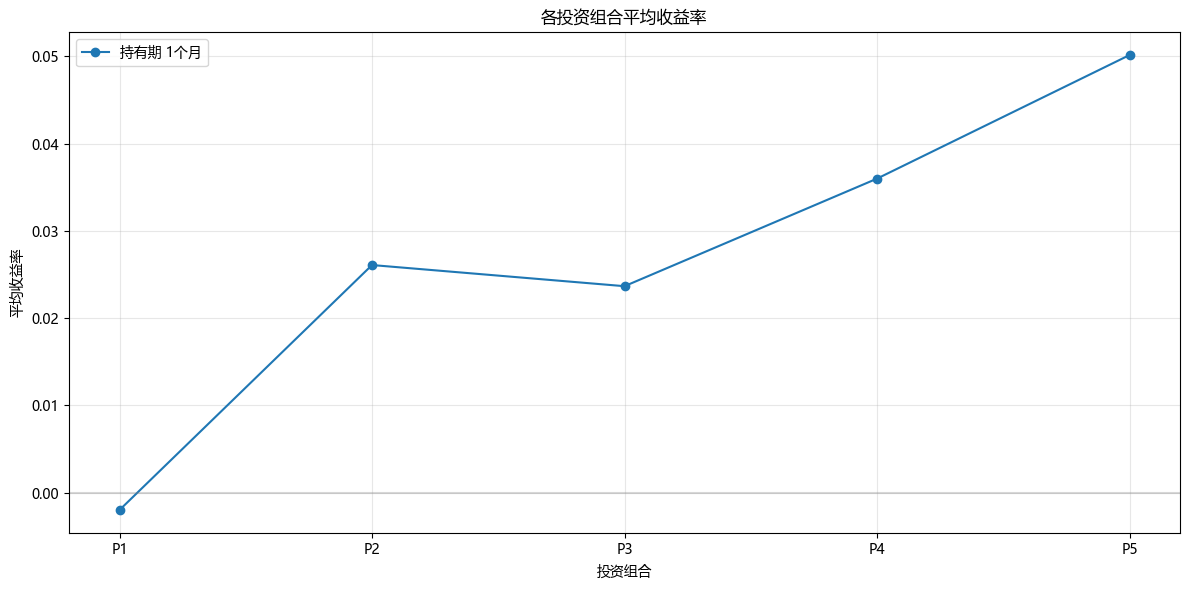

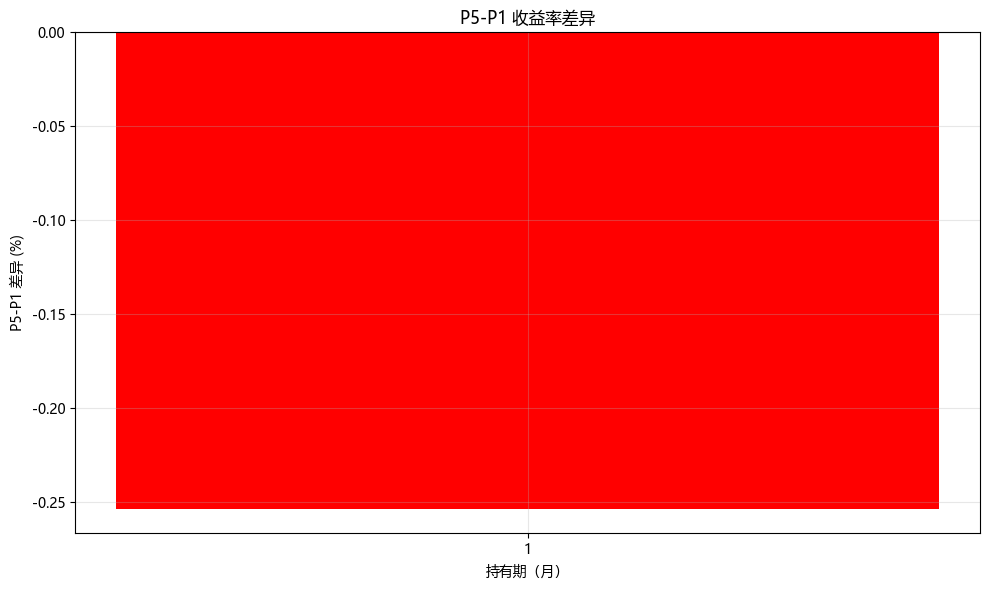


分析形成期N=1月，持有期M=3月的策略...
2. 计算过去1个月的累积收益率...
3. 构建投资组合...
4. 计算持有期3个月的收益率...
形成期结束日期数量: 793
总日期数量: 1660
持有期 3 月的收益率记录数: 1976
5. 检验惯性/反转效应...
6. 可视化结果...


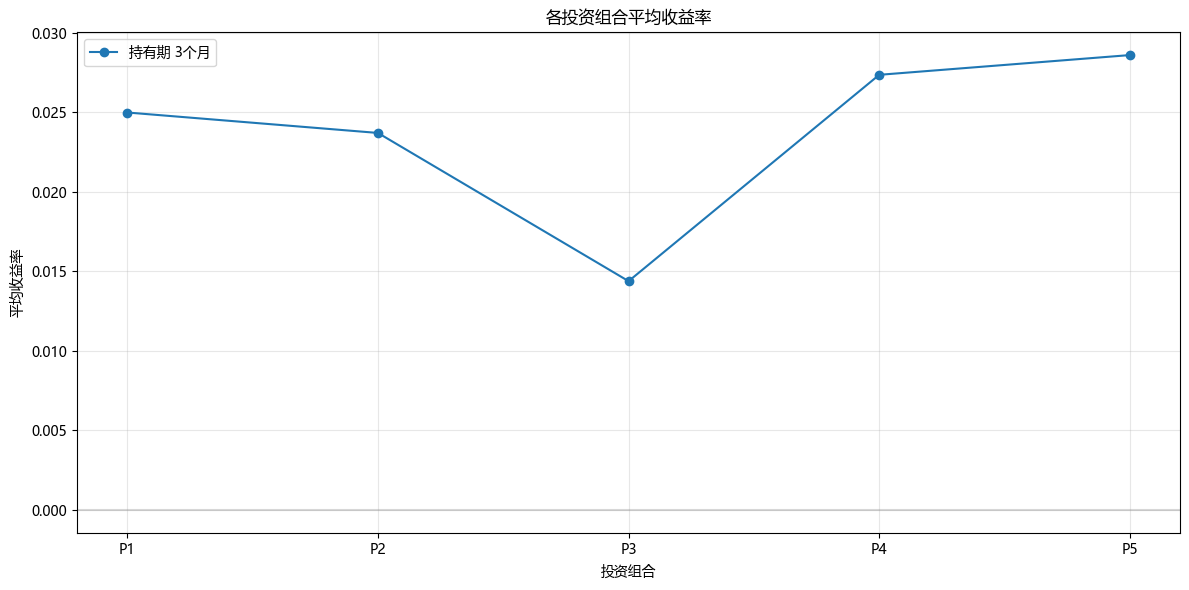

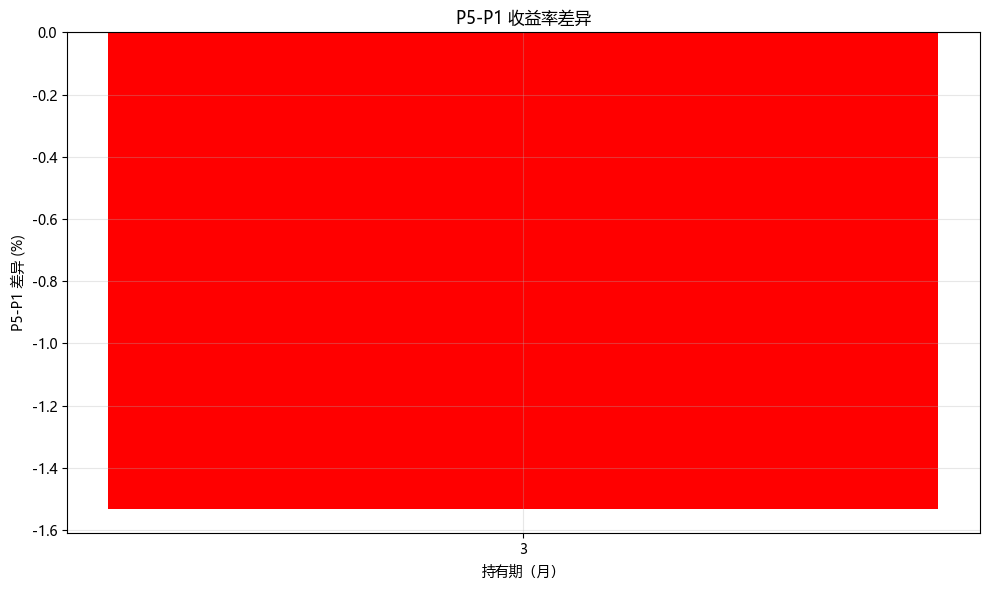


分析形成期N=1月，持有期M=6月的策略...
2. 计算过去1个月的累积收益率...
3. 构建投资组合...
4. 计算持有期6个月的收益率...
形成期结束日期数量: 793
总日期数量: 1660
持有期 6 月的收益率记录数: 2774
5. 检验惯性/反转效应...
6. 可视化结果...


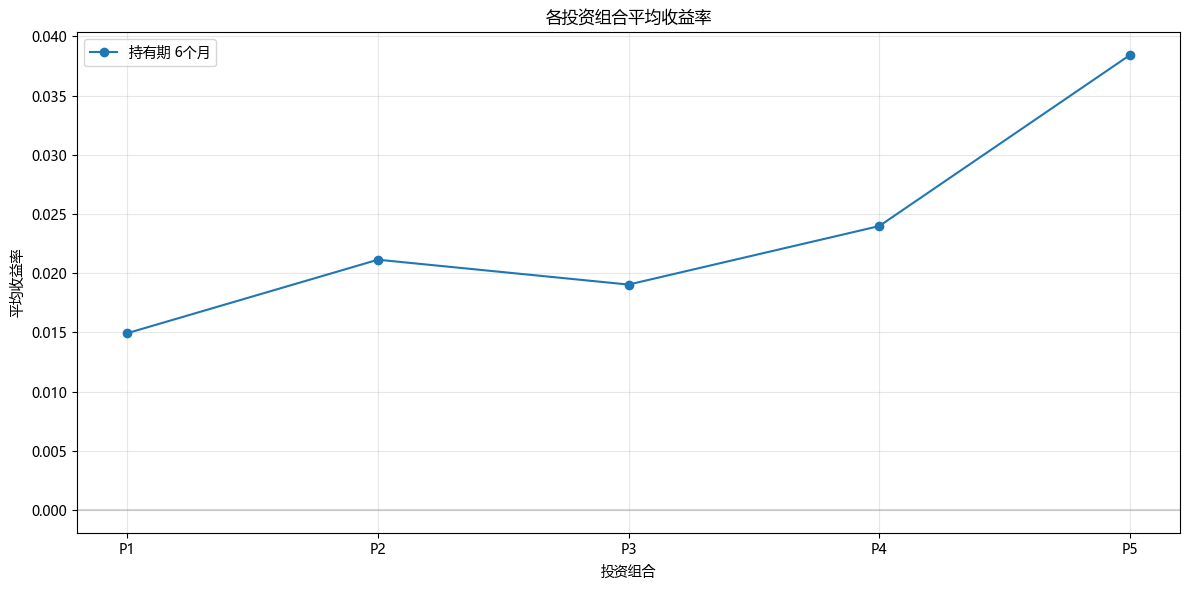

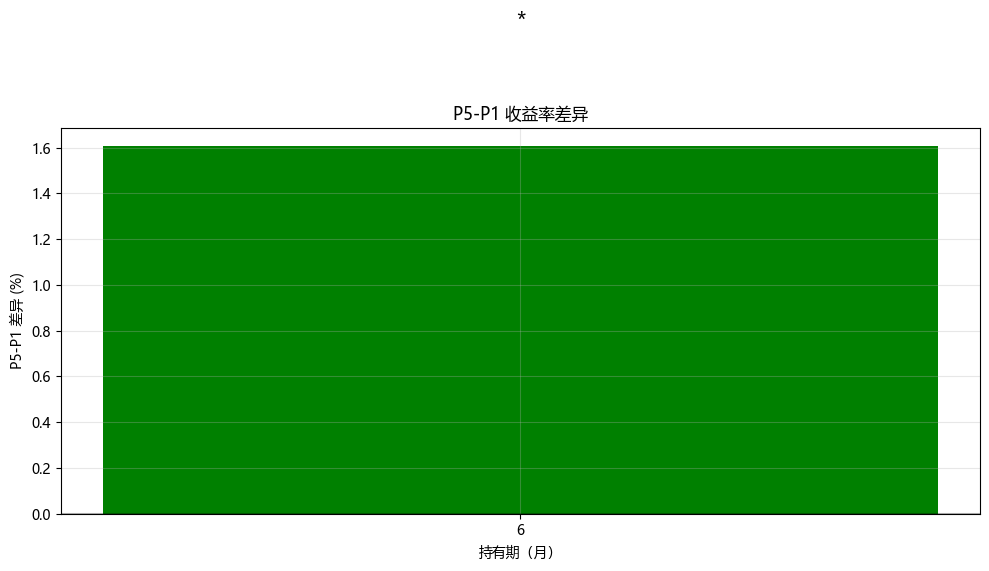


分析形成期N=1月，持有期M=12月的策略...
2. 计算过去1个月的累积收益率...
3. 构建投资组合...
4. 计算持有期12个月的收益率...
形成期结束日期数量: 793
总日期数量: 1660
持有期 12 月的收益率记录数: 3458
5. 检验惯性/反转效应...
6. 可视化结果...


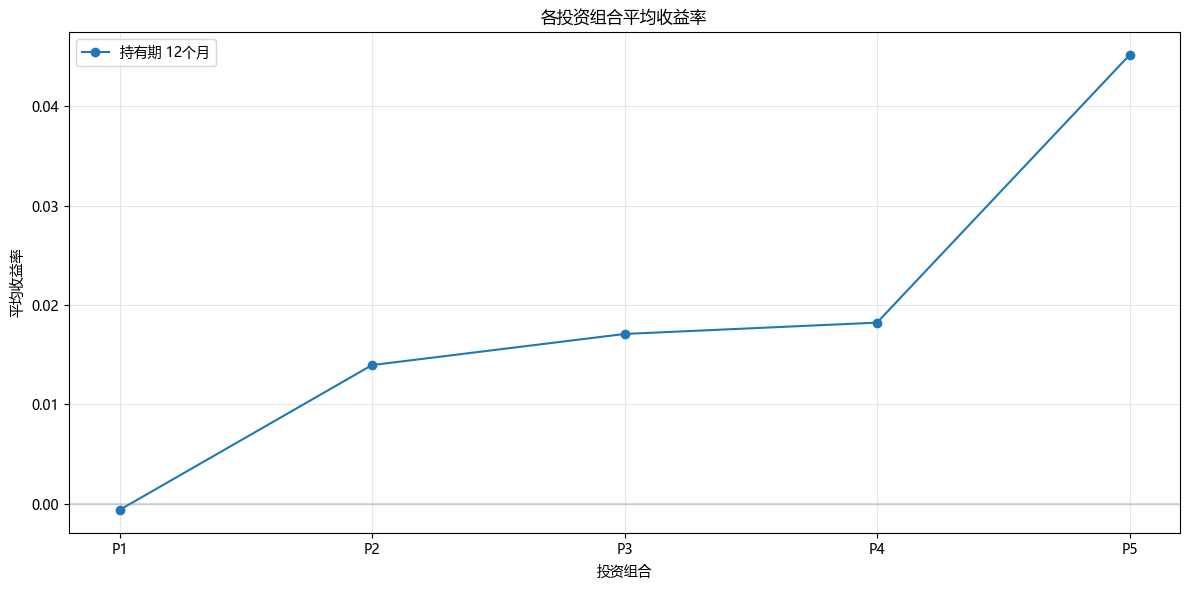

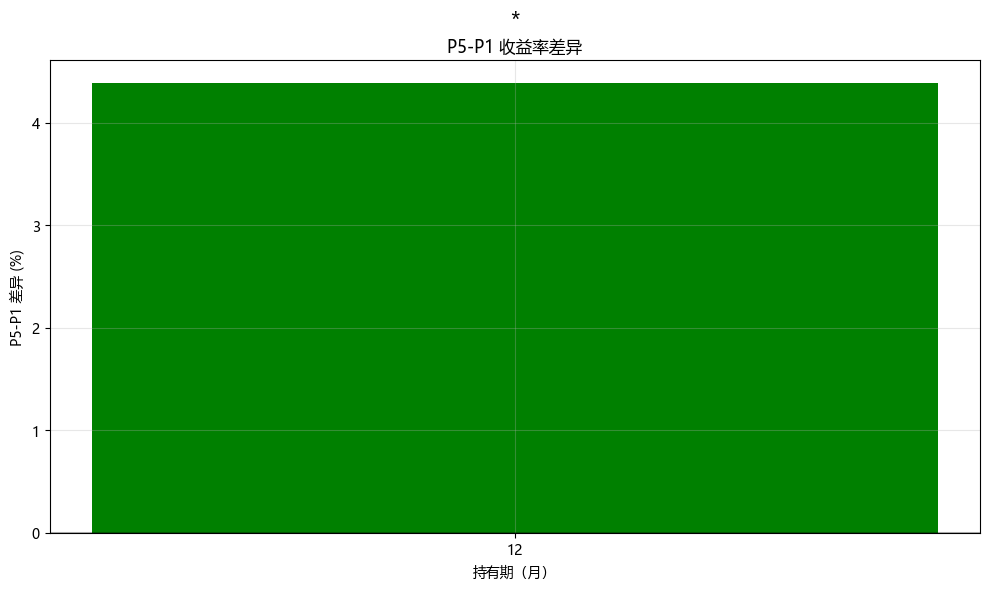


分析形成期N=3月，持有期M=1月的策略...
2. 计算过去3个月的累积收益率...
3. 构建投资组合...
4. 计算持有期1个月的收益率...
形成期结束日期数量: 18
总日期数量: 1660
持有期 1 月的收益率记录数: 26
5. 检验惯性/反转效应...
6. 可视化结果...


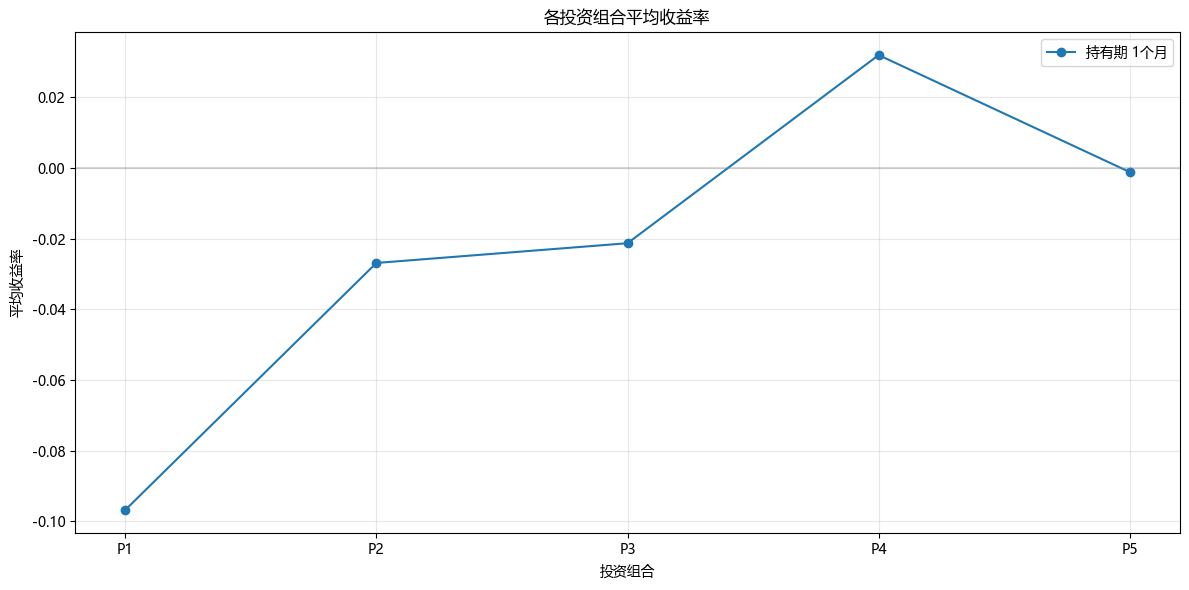

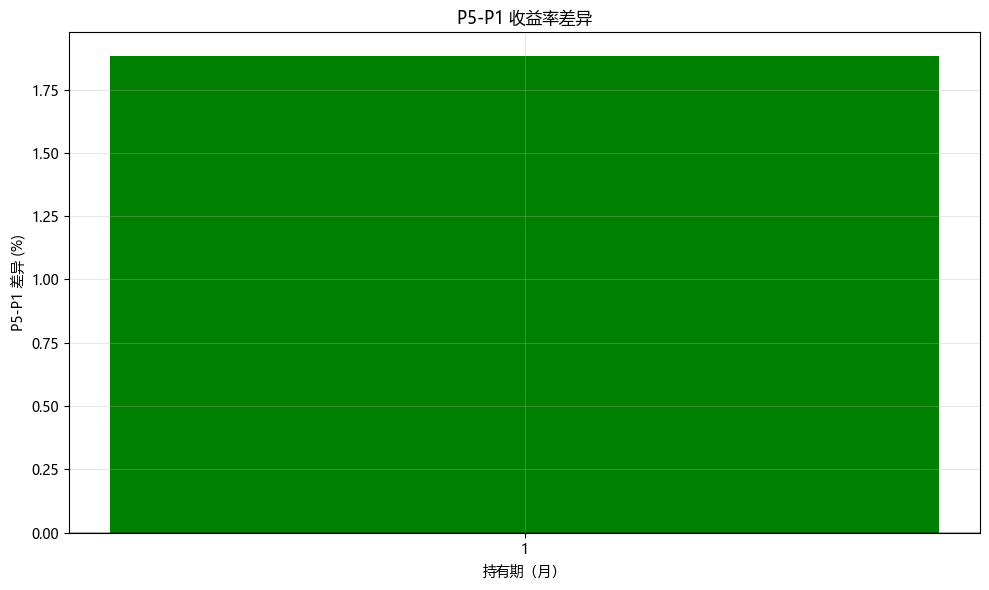


分析形成期N=3月，持有期M=3月的策略...
2. 计算过去3个月的累积收益率...
3. 构建投资组合...
4. 计算持有期3个月的收益率...
形成期结束日期数量: 18
总日期数量: 1660
持有期 3 月的收益率记录数: 67
5. 检验惯性/反转效应...
6. 可视化结果...


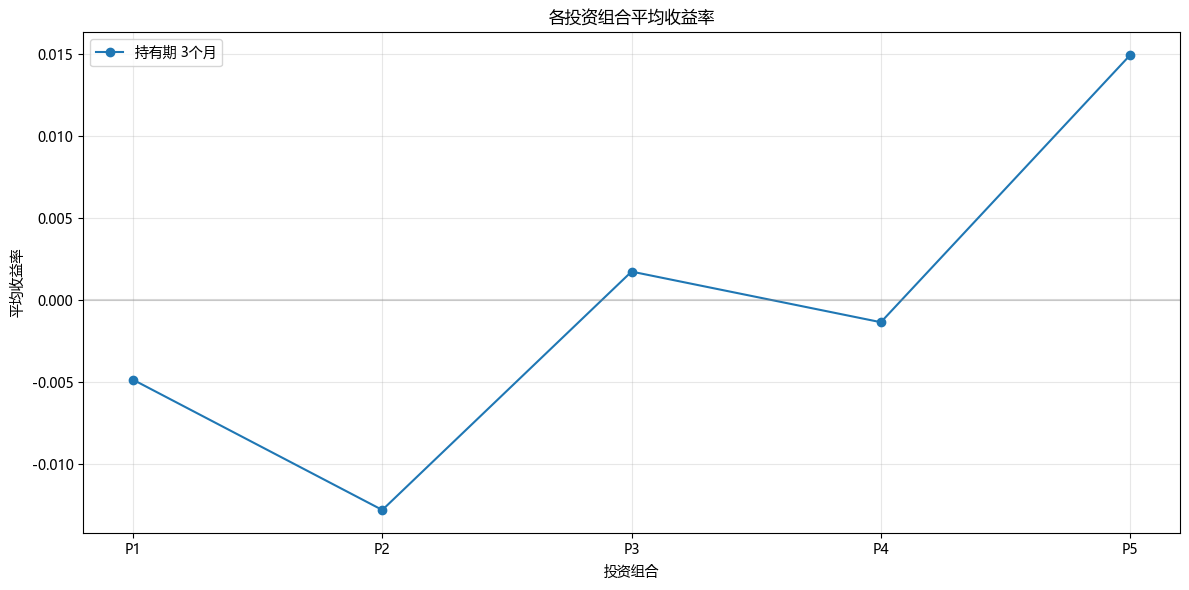

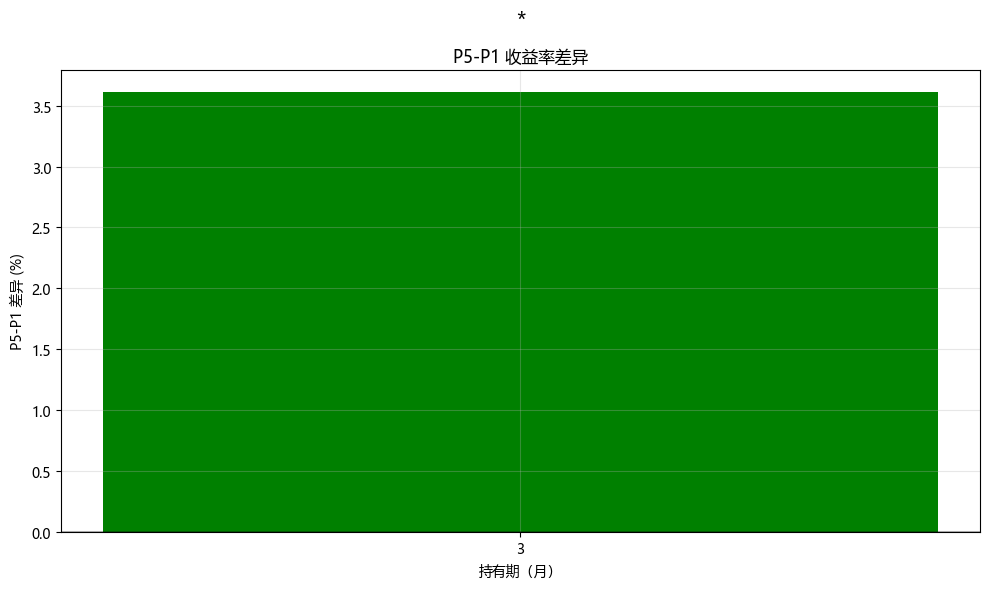


分析形成期N=3月，持有期M=6月的策略...
2. 计算过去3个月的累积收益率...
3. 构建投资组合...
4. 计算持有期6个月的收益率...
形成期结束日期数量: 18
总日期数量: 1660
持有期 6 月的收益率记录数: 90
5. 检验惯性/反转效应...
6. 可视化结果...


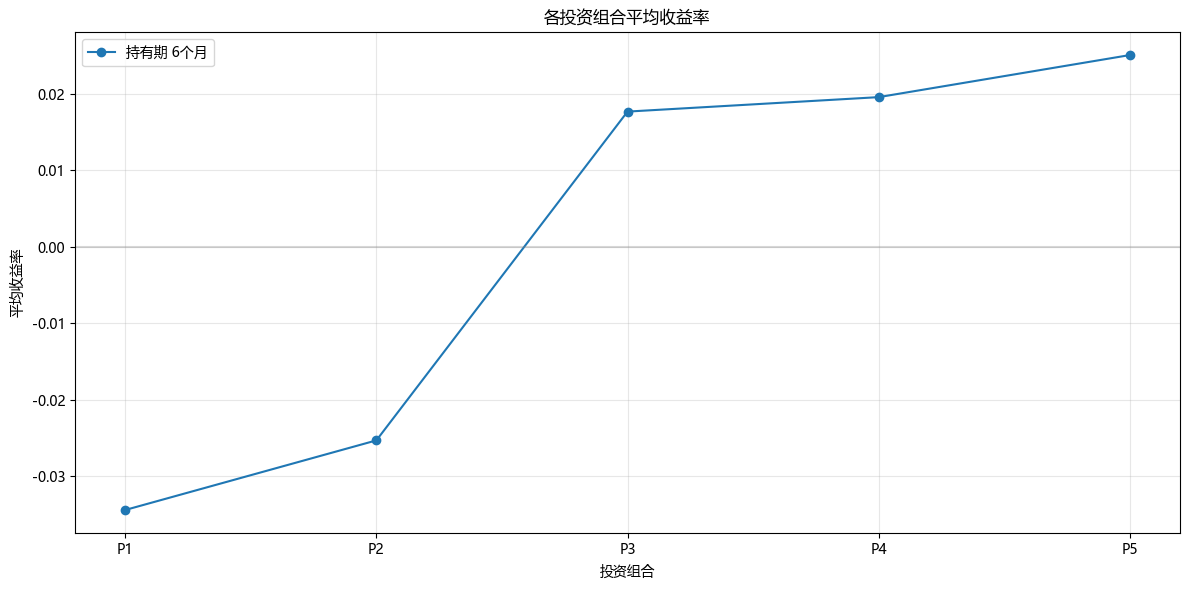

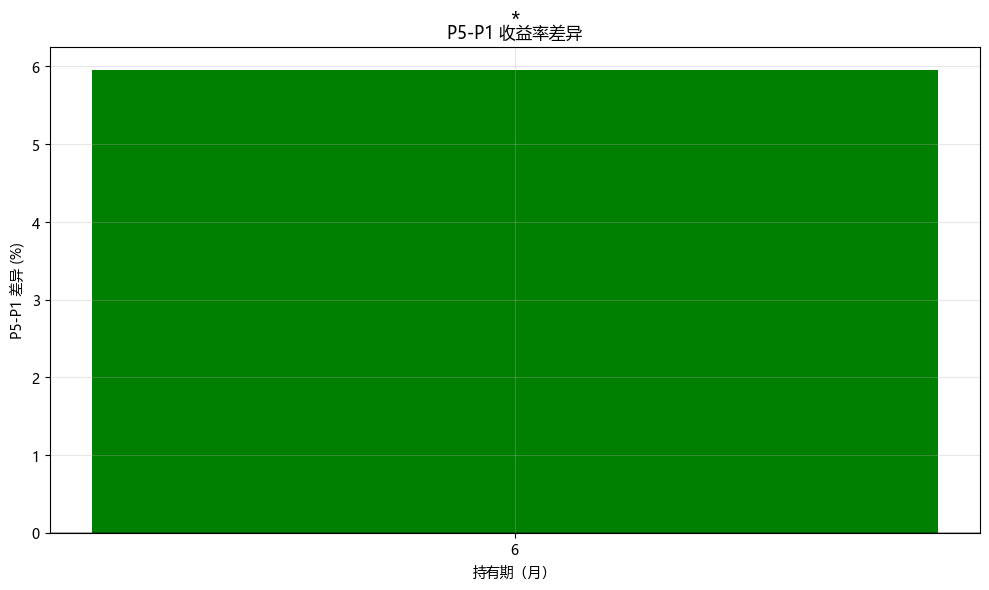


分析形成期N=3月，持有期M=12月的策略...
2. 计算过去3个月的累积收益率...
3. 构建投资组合...
4. 计算持有期12个月的收益率...
形成期结束日期数量: 18
总日期数量: 1660
持有期 12 月的收益率记录数: 90
5. 检验惯性/反转效应...
6. 可视化结果...


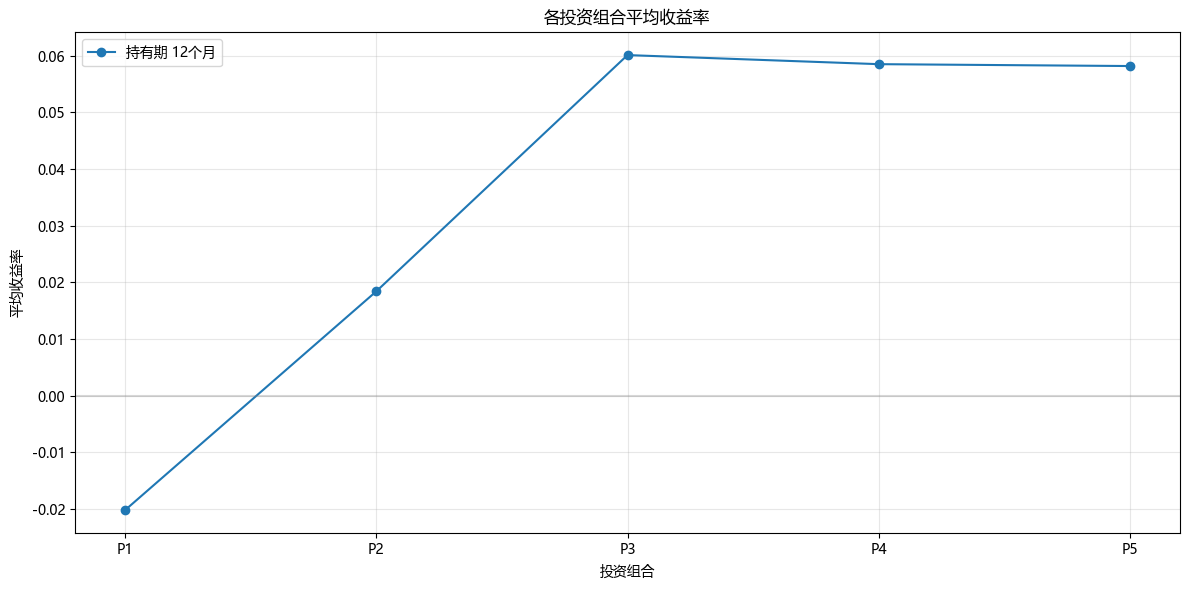

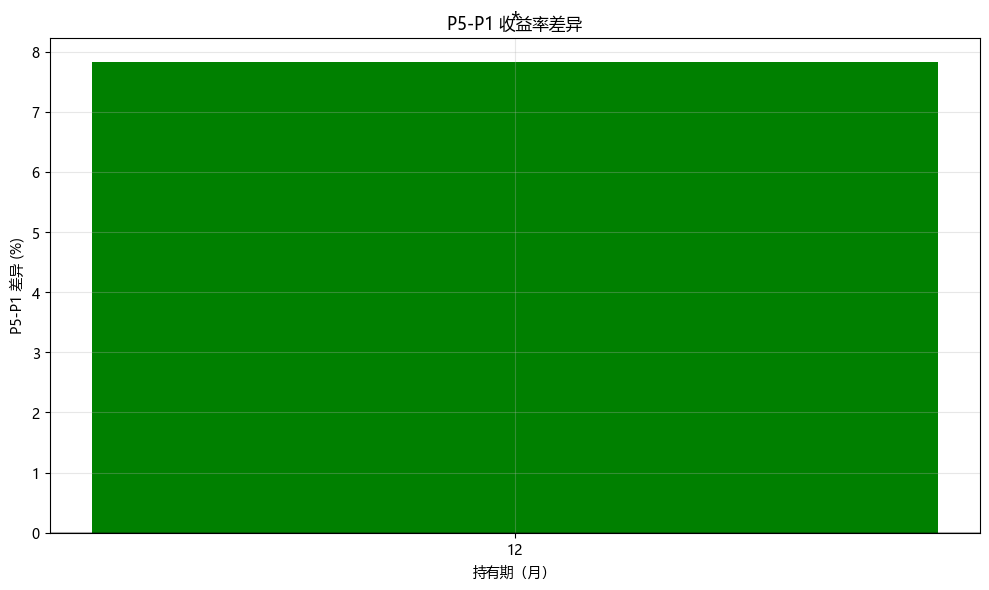


分析形成期N=6月，持有期M=1月的策略...
2. 计算过去6个月的累积收益率...
3. 构建投资组合...
4. 计算持有期1个月的收益率...
形成期结束日期数量: 1
总日期数量: 1660
持有期 1 月的收益率记录数: 0
警告: 持有期M=1月没有足够的数据

分析形成期N=6月，持有期M=3月的策略...
2. 计算过去6个月的累积收益率...
3. 构建投资组合...
4. 计算持有期3个月的收益率...
形成期结束日期数量: 1
总日期数量: 1660
持有期 3 月的收益率记录数: 5
5. 检验惯性/反转效应...


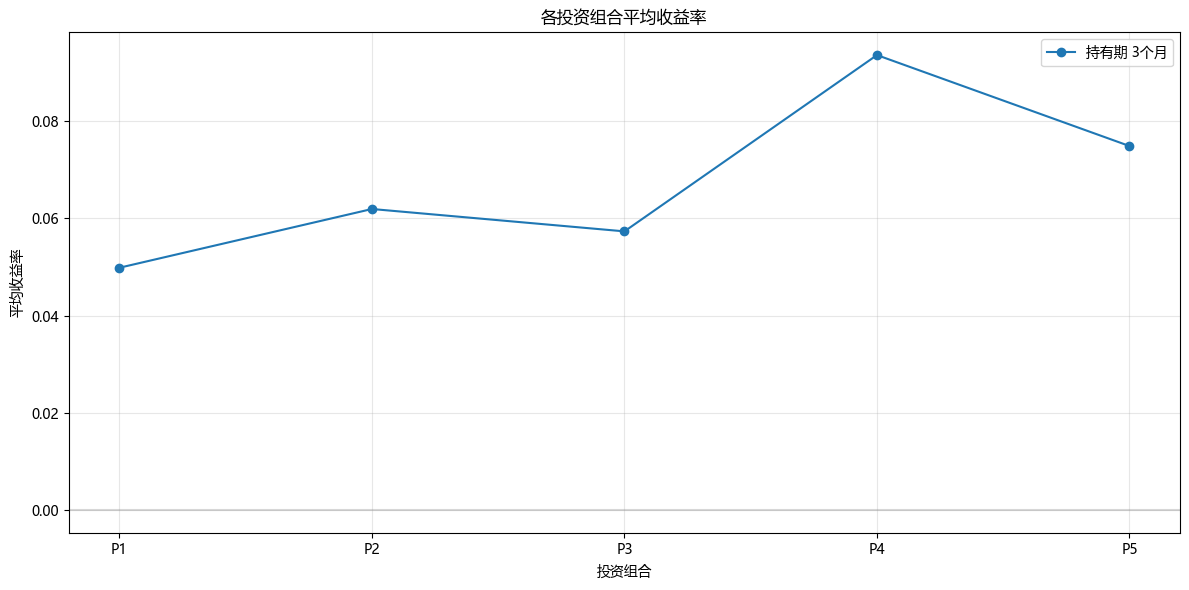

警告: 测试结果数据不完整，跳过P5-P1差异图

分析形成期N=6月，持有期M=6月的策略...
2. 计算过去6个月的累积收益率...
3. 构建投资组合...
4. 计算持有期6个月的收益率...
形成期结束日期数量: 1
总日期数量: 1660
持有期 6 月的收益率记录数: 5
5. 检验惯性/反转效应...


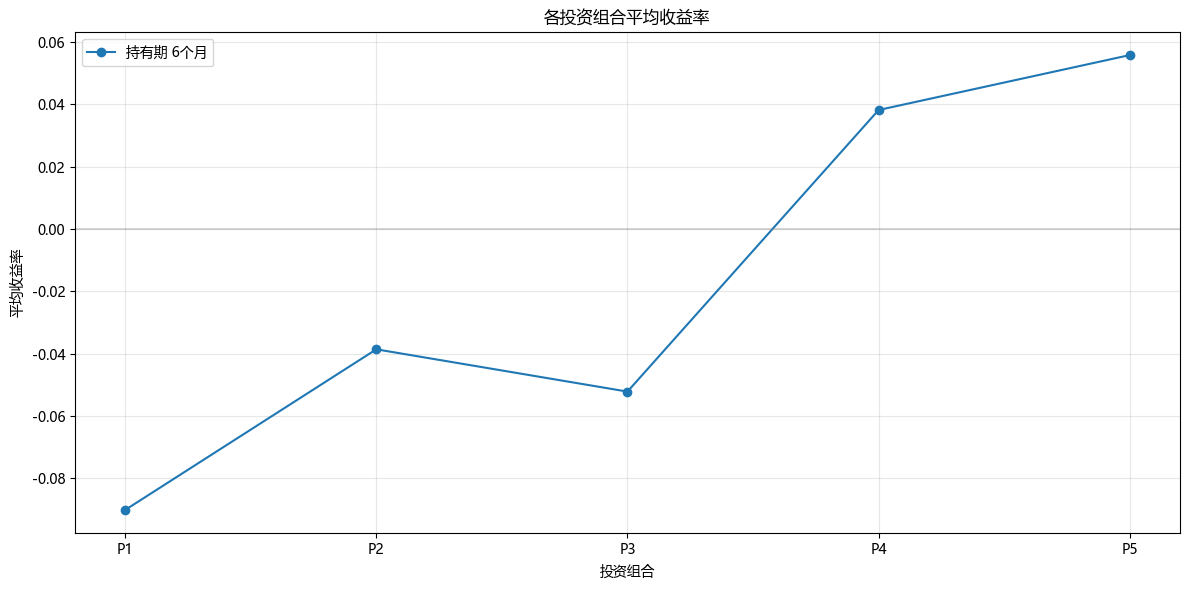

警告: 测试结果数据不完整，跳过P5-P1差异图

分析形成期N=6月，持有期M=12月的策略...
2. 计算过去6个月的累积收益率...
3. 构建投资组合...
4. 计算持有期12个月的收益率...
形成期结束日期数量: 1
总日期数量: 1660
持有期 12 月的收益率记录数: 5
5. 检验惯性/反转效应...


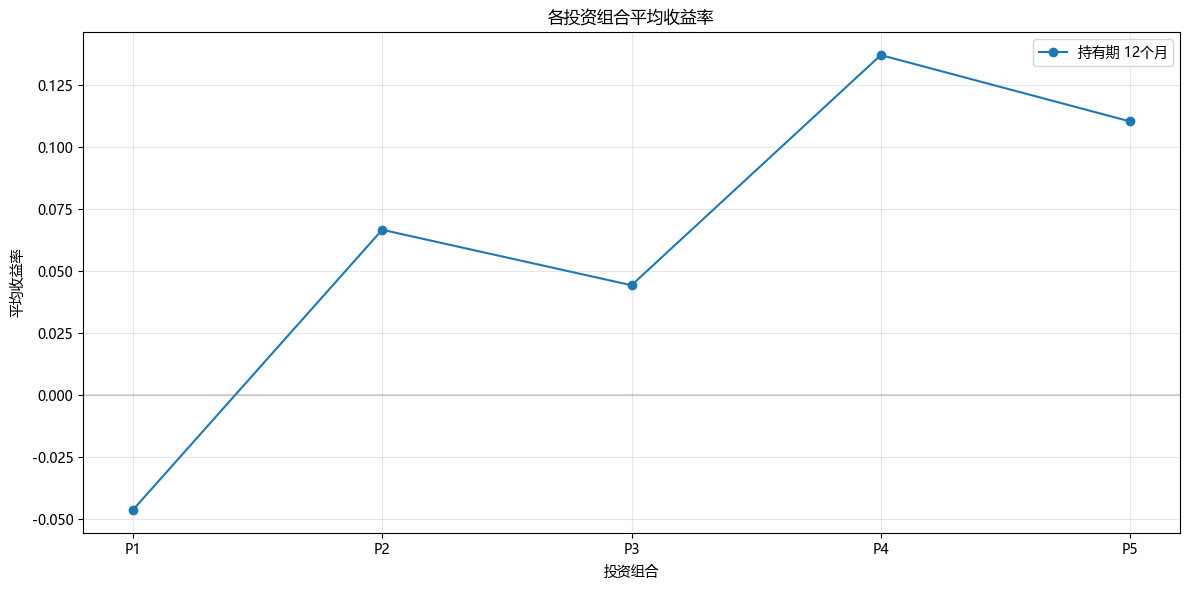

警告: 测试结果数据不完整，跳过P5-P1差异图

分析形成期N=12月，持有期M=1月的策略...
2. 计算过去12个月的累积收益率...
警告: 形成期N=12月没有足够的数据

分析形成期N=12月，持有期M=3月的策略...
2. 计算过去12个月的累积收益率...
警告: 形成期N=12月没有足够的数据

分析形成期N=12月，持有期M=6月的策略...
2. 计算过去12个月的累积收益率...
警告: 形成期N=12月没有足够的数据

分析形成期N=12月，持有期M=12月的策略...
2. 计算过去12个月的累积收益率...
警告: 形成期N=12月没有足够的数据

分析结果汇总:
   FormationPeriod  HoldingPeriod                     EffectType  \
0                1              1  No significant effect (无显著效应)   
1                1              3  No significant effect (无显著效应)   
2                1              6                Momentum (惯性效应)   
3                1             12                Momentum (惯性效应)   
4                3              1  No significant effect (无显著效应)   
5                3              3                Momentum (惯性效应)   
6                3              6                Momentum (惯性效应)   
7                3             12                Momentum (惯性效应)   

   MeanDifference  tStatistic        pValue  
0       -0.002538   -0.254168  8.00121

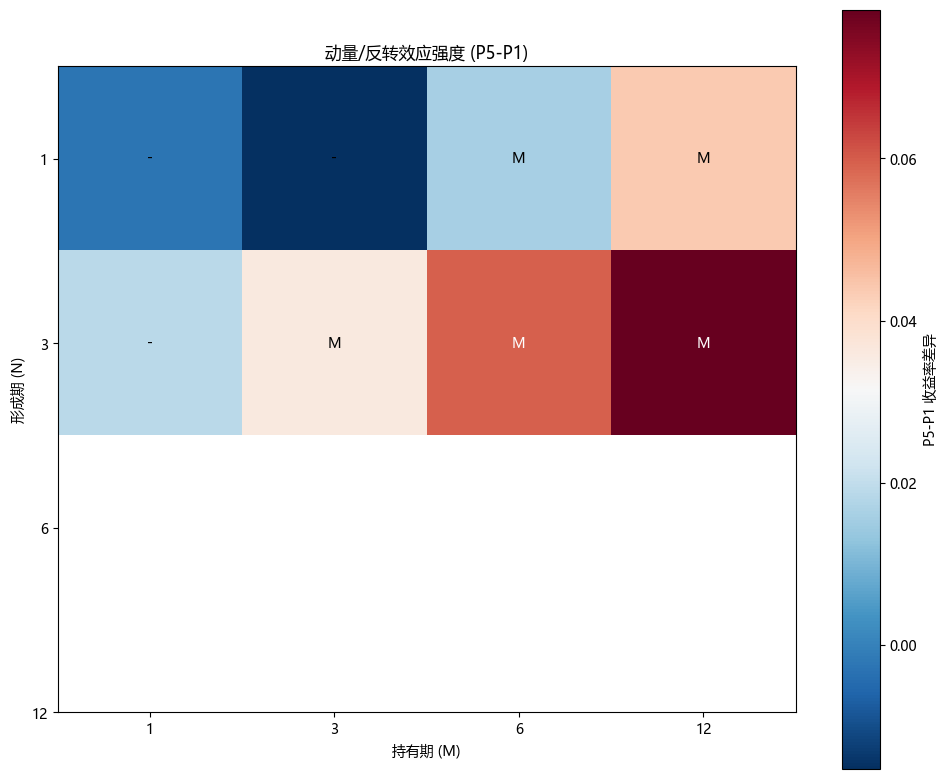

In [62]:
file_path1 = "./assets/data/t3/RESSET_MRESSTK_1.xls"
file_path2 = "./assets/data/t3/RESSET_MRESSTK_2.xls"

# 设置参数
formation_periods = [1, 3, 6, 12]  # 形成期N
holding_periods = [1, 3, 6, 12]    # 持有期M

# 运行分析
results = analyze_momentum_reversal(file_path1, file_path2, formation_periods, holding_periods)